# Components Classification

In [1]:
import pandas as pd
from darts.utils.statistics import extract_trend_and_seasonality, plot_acf, check_seasonality
from darts import TimeSeries
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import darts.models as models
from darts import TimeSeries
from darts.utils.utils import ModelMode, SeasonalityMode
from sklearn.preprocessing import StandardScaler
import warnings
from useful_functions import *
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import itertools
import logging
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf
from scipy.stats import normaltest

C:\Users\bonac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
GENERATE_DATA = False
INPUT_DIR = 'data'
INPUT_DIR = 'C:/Users/bonac/Documents/Datos/4º datos/Proyecto/data'
# INPUT_DIR = 'C:/Users/Curro/OneDrive - Universidad Carlos III de Madrid/Cuarto/Data Science Project/Sandoz'

In [3]:
sales_data = pd.read_csv(f'{INPUT_DIR}/sales_data_v2.csv')
sales_data.head()

country_name    molecule    dosage_form    strength  standard_units  \
0    COUNTRY_A  MOLECULE_A  DOSAGE_FORM_1  STRENGTH_1    1.339771e+07   
1    COUNTRY_B  MOLECULE_A  DOSAGE_FORM_2  STRENGTH_2    9.109434e+04   
2    COUNTRY_C  MOLECULE_B  DOSAGE_FORM_3  STRENGTH_3    5.854595e+03   
3    COUNTRY_D  MOLECULE_A  DOSAGE_FORM_4  STRENGTH_4    1.194021e+05   
4    COUNTRY_B  MOLECULE_B  DOSAGE_FORM_5  STRENGTH_5    2.156079e+03   

         date  
0  2013-02-01  
1  2013-02-01  
2  2013-02-01  
3  2013-02-01  
4  2013-02-01

In [4]:
sales_data_country = {country: group for country, group in sales_data.groupby("country_name")}

sales_data_country['COUNTRY_A'].head(), sales_data_country['COUNTRY_B'].head() 

(   country_name    molecule     dosage_form     strength  standard_units  \
 0     COUNTRY_A  MOLECULE_A   DOSAGE_FORM_1   STRENGTH_1    1.339771e+07   
 7     COUNTRY_A  MOLECULE_D   DOSAGE_FORM_8   STRENGTH_8    7.845177e+06   
 11    COUNTRY_A  MOLECULE_A  DOSAGE_FORM_12   STRENGTH_3    4.273628e+06   
 20    COUNTRY_A  MOLECULE_C  DOSAGE_FORM_18   STRENGTH_1    4.001037e+03   
 28    COUNTRY_A  MOLECULE_D   DOSAGE_FORM_9  STRENGTH_19    4.697322e+04   
 
           date  
 0   2013-02-01  
 7   2013-02-01  
 11  2013-02-01  
 20  2013-02-01  
 28  2013-02-01  ,
    country_name    molecule     dosage_form     strength  standard_units  \
 1     COUNTRY_B  MOLECULE_A   DOSAGE_FORM_2   STRENGTH_2    9.109434e+04   
 4     COUNTRY_B  MOLECULE_B   DOSAGE_FORM_5   STRENGTH_5    2.156079e+03   
 23    COUNTRY_B  MOLECULE_A   DOSAGE_FORM_2   STRENGTH_4    2.897231e+04   
 25    COUNTRY_B  MOLECULE_D   DOSAGE_FORM_9  STRENGTH_17    3.988746e+05   
 27    COUNTRY_B  MOLECULE_A  DOSAGE_FORM_

In [5]:
GENERATE_DATA = False
if GENERATE_DATA:

    sales_data_molec = {}

    for country, sales_data in sales_data_country.items():
        country_molec_df = sales_data.groupby(['date', 'molecule'])['standard_units'].sum().unstack()
        country_molec_df.index = pd.to_datetime(country_molec_df.index)
        country_molec_df.to_csv(f'{INPUT_DIR}/sales_data_molec_{country}.csv')
        sales_data_molec[country] = country_molec_df
else:
    sales_data_molec = {}
    country_files = [f for f in os.listdir(INPUT_DIR) if f.startswith('sales_data_molec_') and f.endswith('.csv')]
    for country_file in country_files:
        country_name = country_file.replace('sales_data_molec_', '').replace('.csv', '')
        country_df = pd.read_csv(f'{INPUT_DIR}/{country_file}', index_col='date', parse_dates=['date'])
        sales_data_molec[country_name] = country_df



In [6]:
df = sales_data_molec['COUNTRY_A']['MOLECULE_A']
df = pd.DataFrame(df)

In [7]:
df.reset_index(inplace=True)  # Restaura 'date' como columna si ya es índice
df.set_index('date', inplace=True)
df = df.asfreq(pd.infer_freq(df.index))

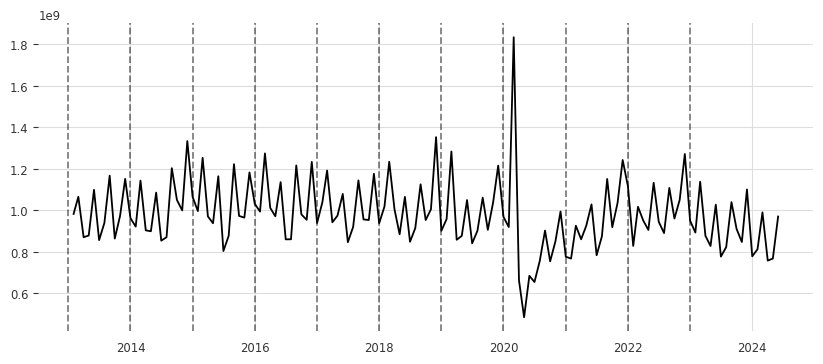

In [8]:
from datetime import datetime
plt.figure(figsize=(10,4))
plt.plot(df)
for year in range(2013, 2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

In [9]:
stl = STL(df)
result = stl.fit()

In [10]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

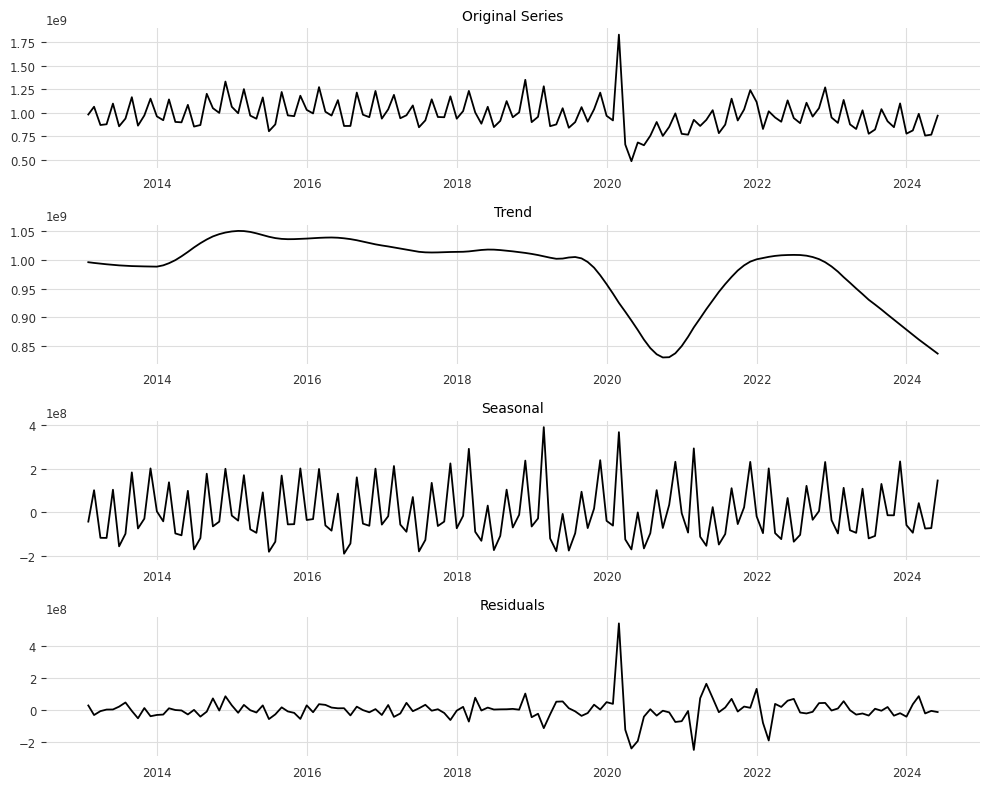

In [11]:
plt.figure(figsize=(10,8))

plt.subplot(4, 1, 1)
plt.plot(df)
plt.title('Original Series', fontsize=10)

plt.subplot(4, 1, 2)
plt.plot(trend)
plt.title('Trend', fontsize=10)

plt.subplot(4, 1, 3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=10)

plt.subplot(4, 1, 4)
plt.plot(resid)
plt.title('Residuals', fontsize=10)

plt.tight_layout()

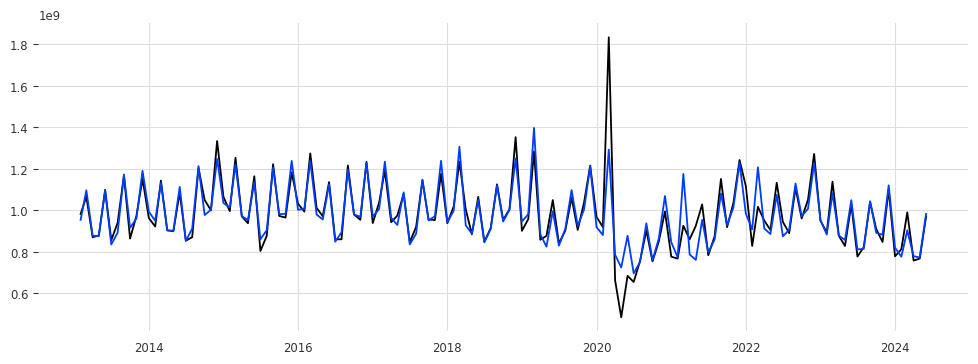

In [12]:
estimated = trend+seasonal
plt.figure(figsize=(12,4))
plt.plot(df)
plt.plot(estimated)

### Anomaly detection seasonal-trend approach

In [13]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu- 1.5*resid_dev
upper = resid_mu+ 1.5*resid_dev

(15706.0, 19936.0)

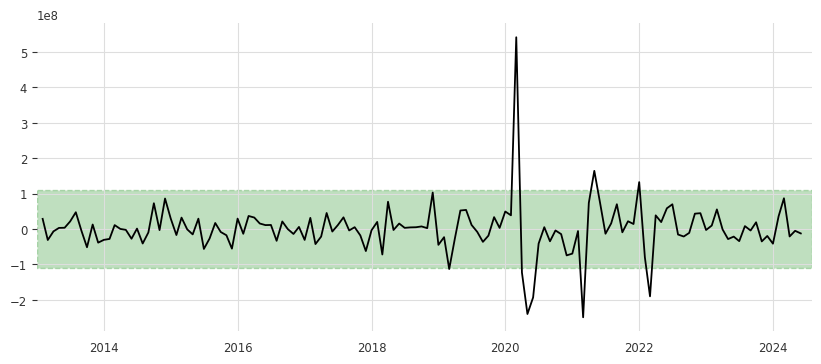

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(resid)

plt.fill_between([datetime(2013,1,1), datetime(2024, 8,1)], lower, upper, color='g', alpha=0.25, linestyle='--')
plt.xlim(datetime(2013,1,1), datetime(2024, 8,1))

In [15]:
anomalies = df[(resid < lower) | (resid > upper)]

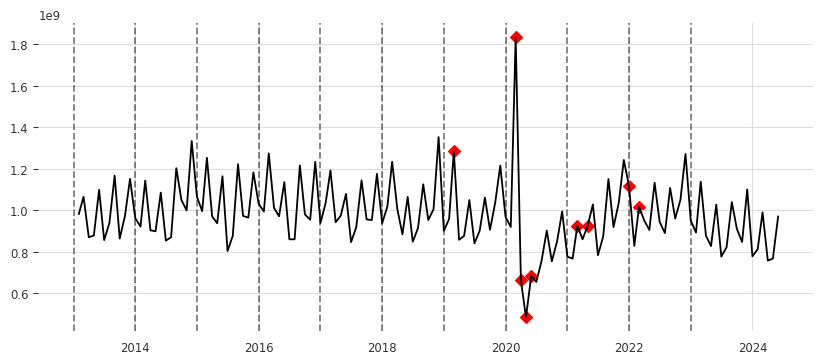

In [16]:
plt.figure(figsize=(10,4))
plt.plot(df)
for year in range(2013, 2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
plt.scatter(anomalies.index, anomalies.MOLECULE_A, color='r', marker='D')

## Decomposition

In [17]:
def normalize_component(component):
    scaler = MinMaxScaler()
    if isinstance(component, pd.Series):
        component = component.to_numpy()
    component_normalized = scaler.fit_transform(component.reshape(-1, 1))
    return component_normalized.flatten()

def decomposition(country, value, plot=False):
    df = sales_data_molec[country][value]
    df = pd.DataFrame(df)
    df = df.interpolate(method='linear').dropna()
    df.reset_index(inplace=True)  # Restaura 'date' como columna si ya es índice
    df.set_index('date', inplace=True)
    df = df.asfreq(pd.infer_freq(df.index))
    stl = STL(df)
    result = stl.fit()
    seasonal, trend, resid = result.seasonal, result.trend, result.resid
    trend = normalize_component(trend)
    seasonal = normalize_component(seasonal)
    resid = normalize_component(resid)
    if plot:
        plt.figure(figsize=(10,8))

        plt.subplot(4, 1, 1)
        plt.plot(df)
        plt.title('Original Series', fontsize=10)

        plt.subplot(4, 1, 2)
        plt.plot(trend)
        plt.title('Trend', fontsize=10)

        plt.subplot(4, 1, 3)
        plt.plot(seasonal)
        plt.title('Seasonal', fontsize=10)

        plt.subplot(4, 1, 4)
        plt.plot(resid)
        plt.title('Residuals', fontsize=10)
        residuals_dist(resid, country, value)
    return seasonal, trend, resid

def residuals_dist(resid, country, molecule):
    #residuals = resid.dropna()  # Drop NaN values in the residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(resid, kde=True, bins=30, color='blue')
    plt.title(f'Residual Distribution: {country} - {molecule}')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.show()

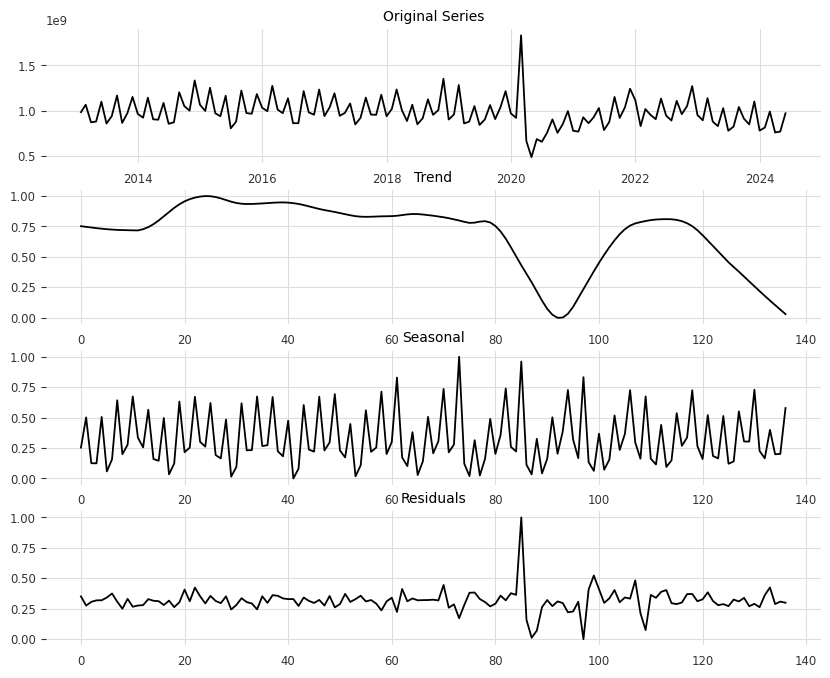

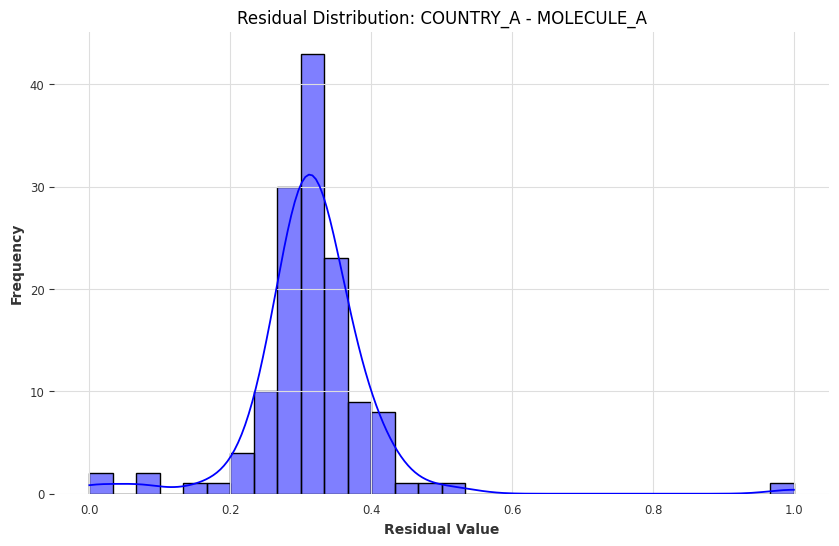

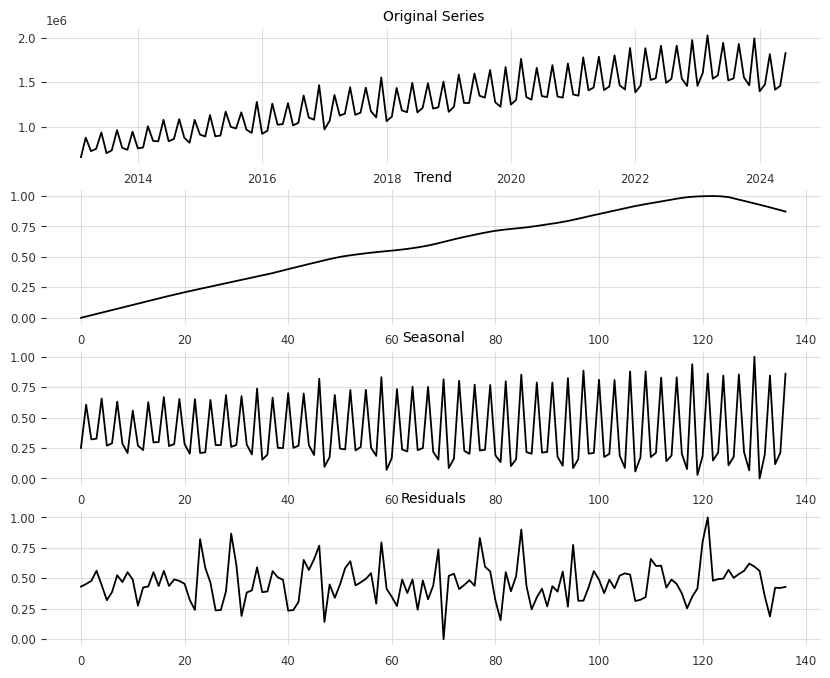

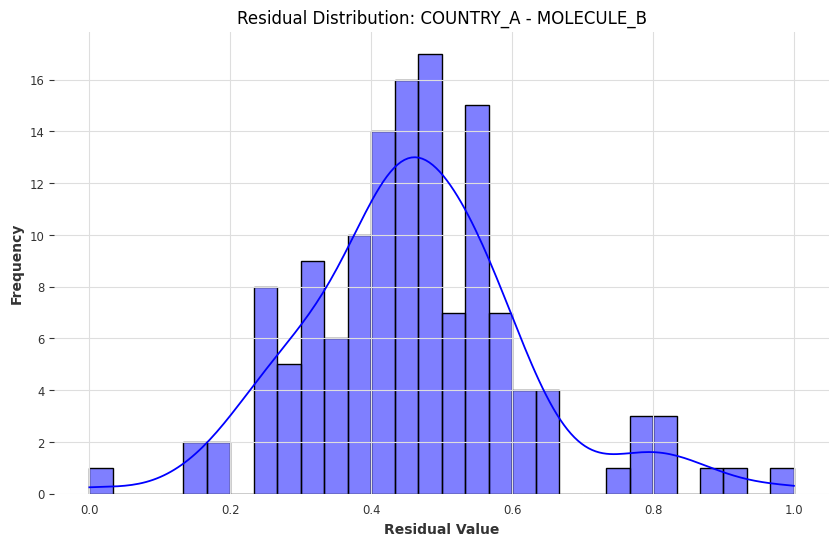

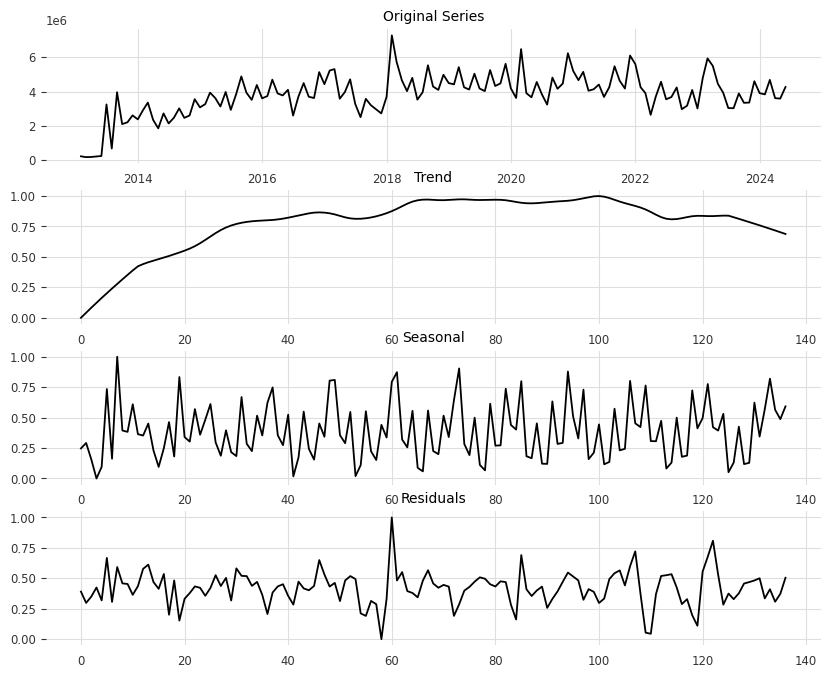

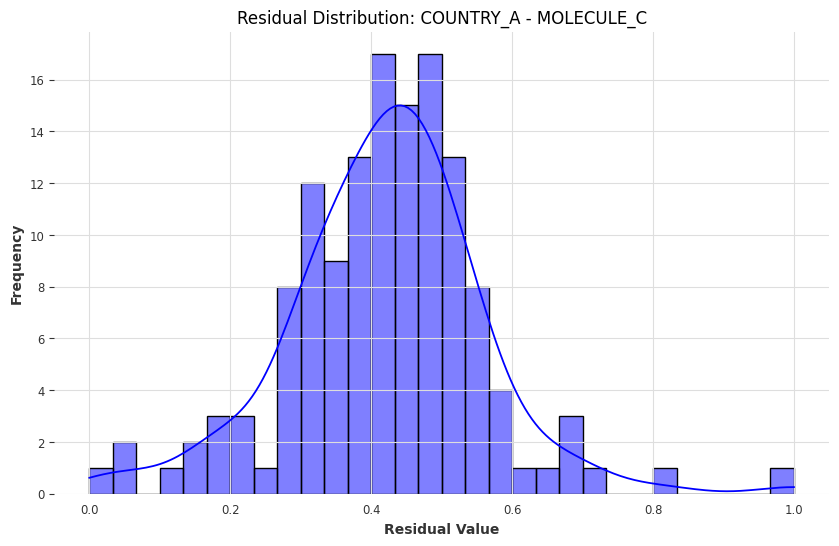

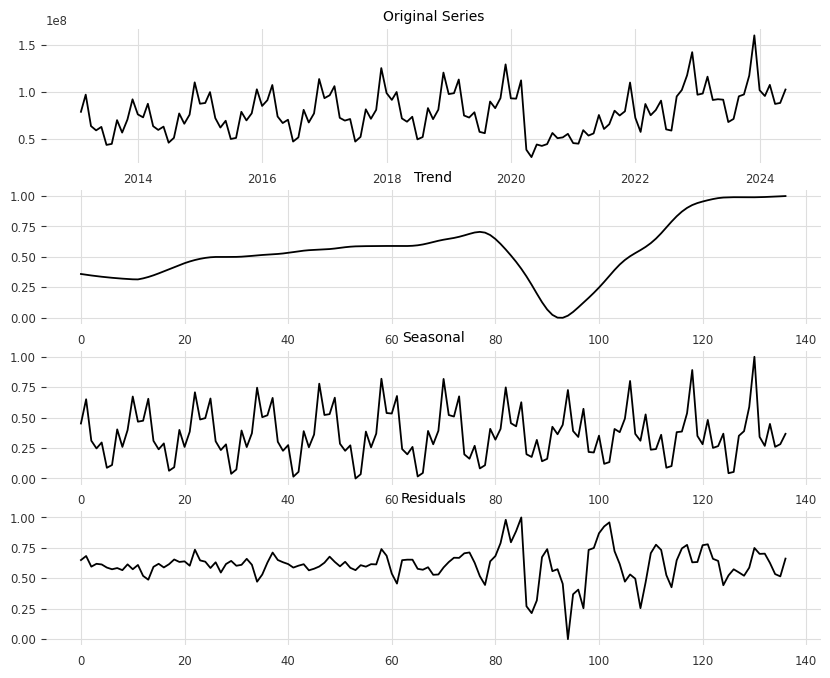

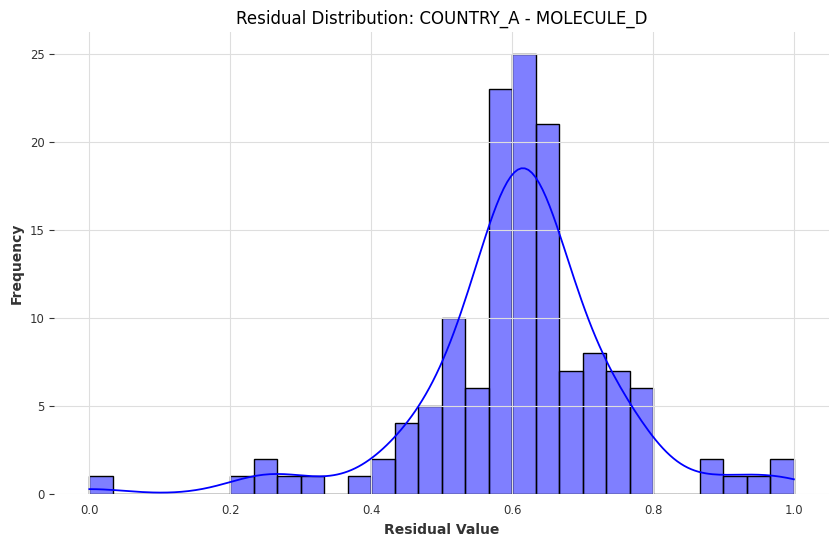

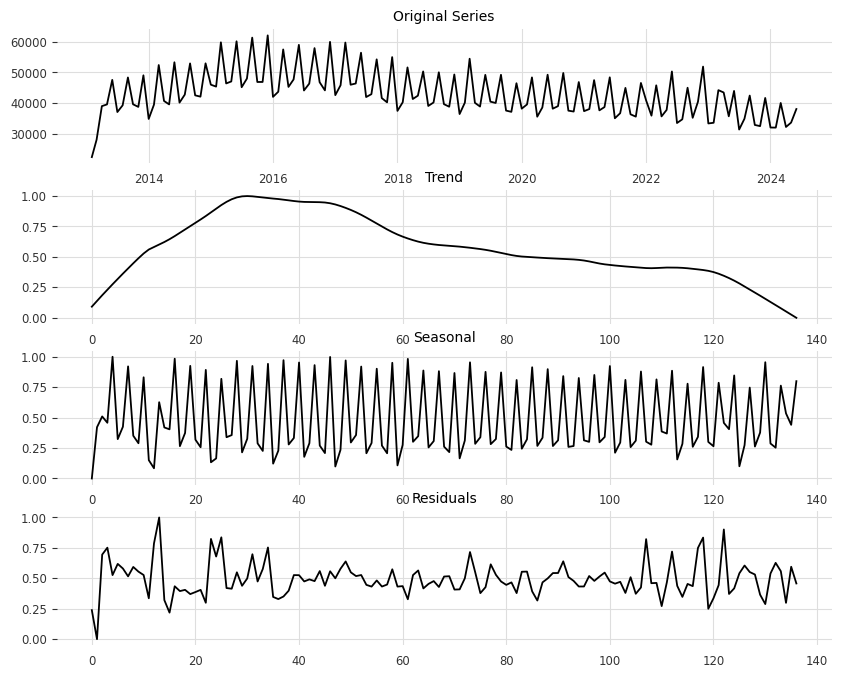

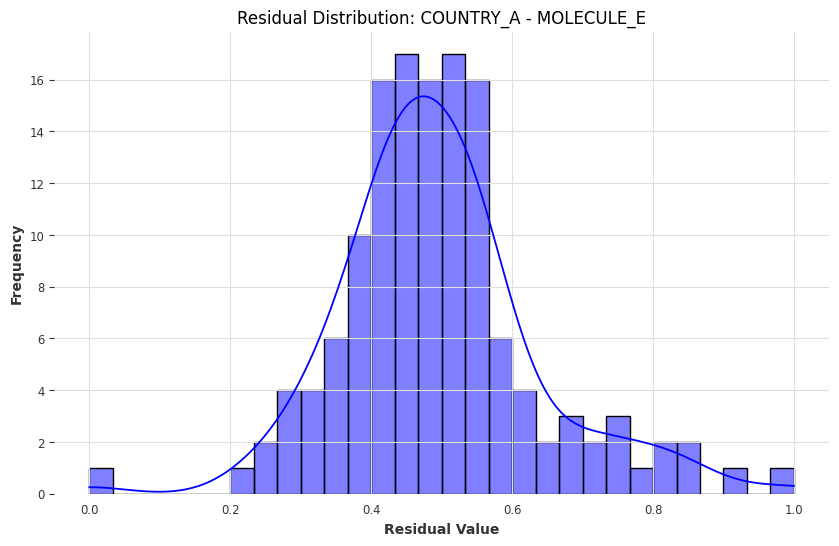

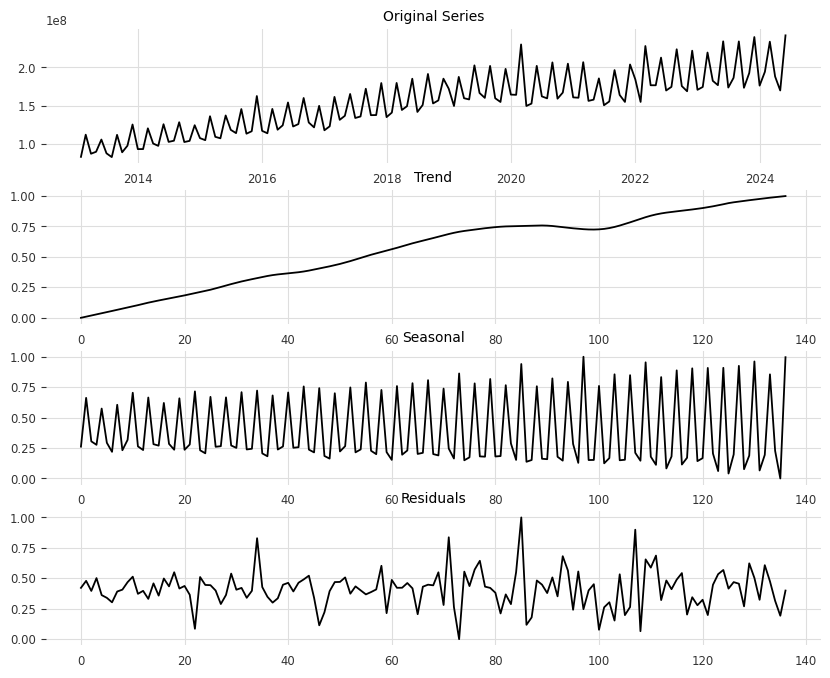

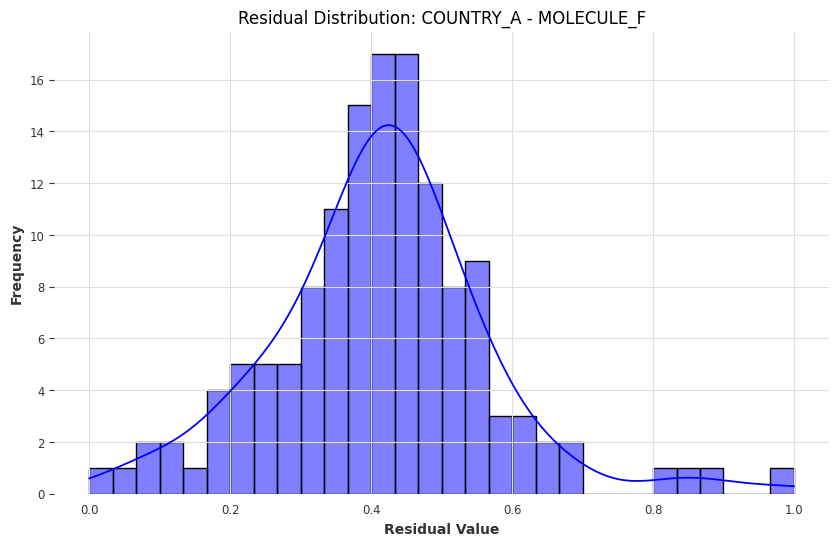

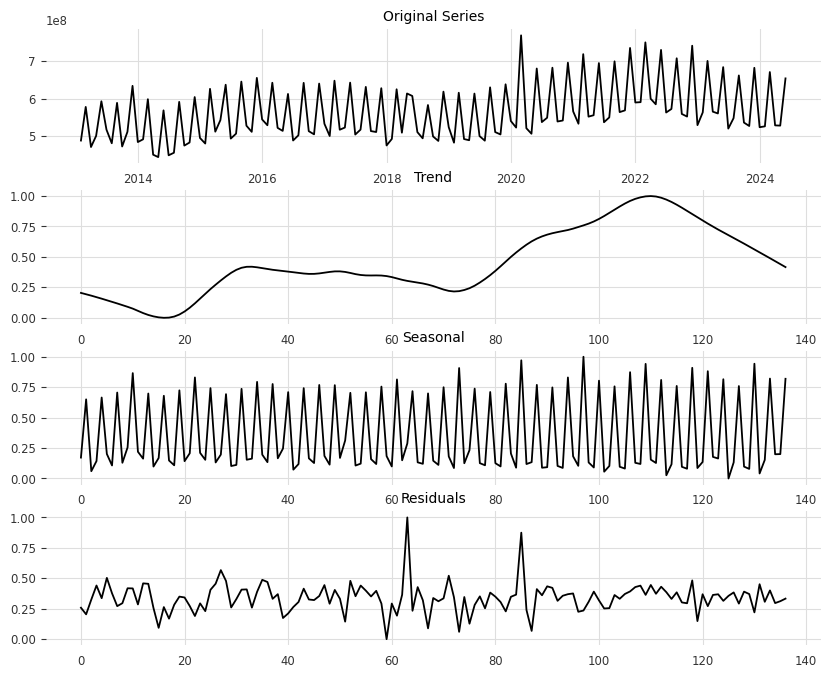

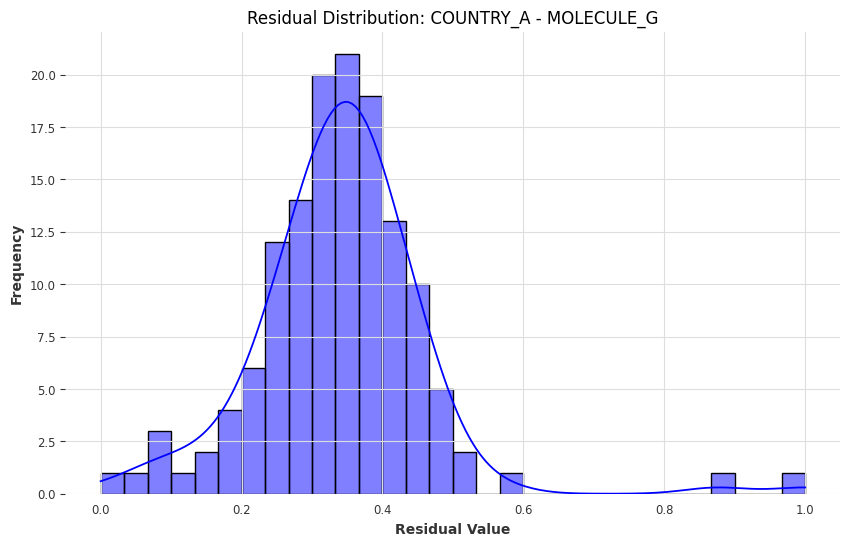

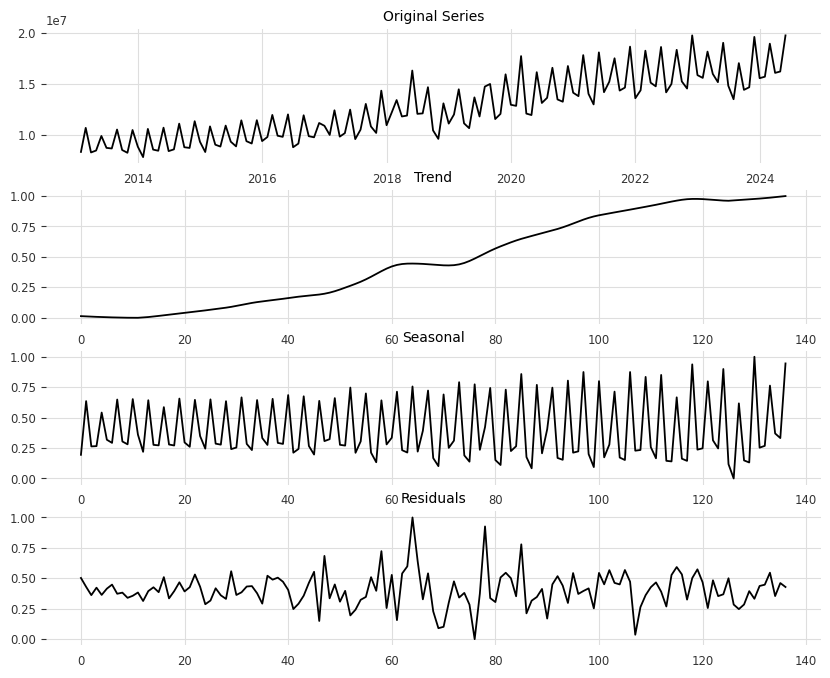

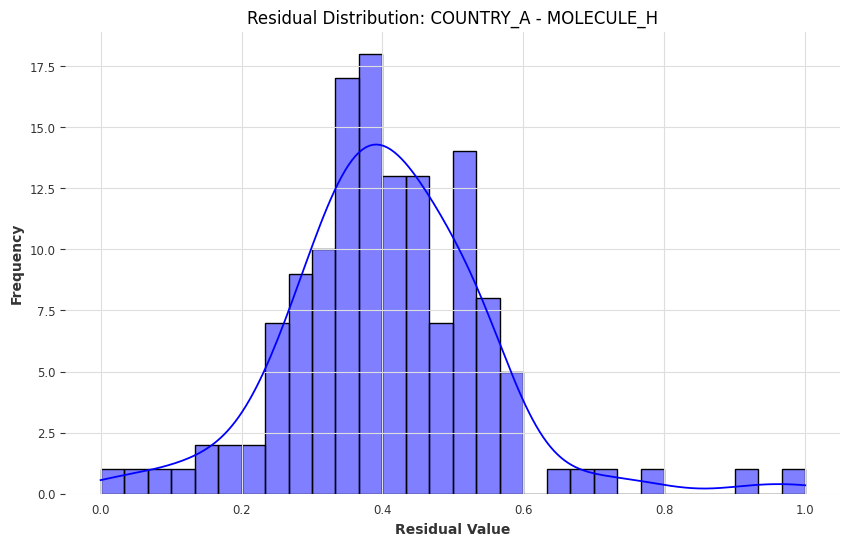

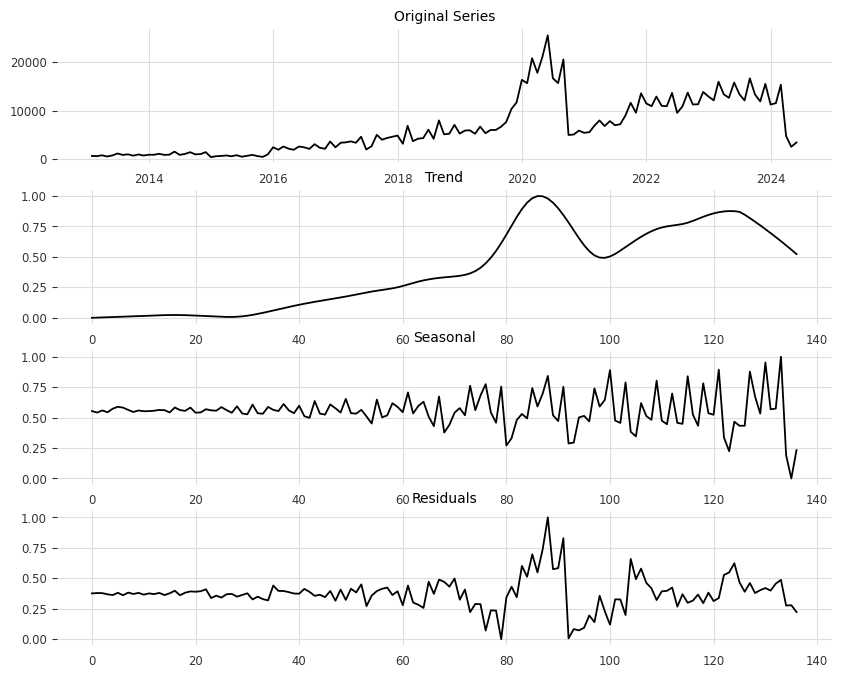

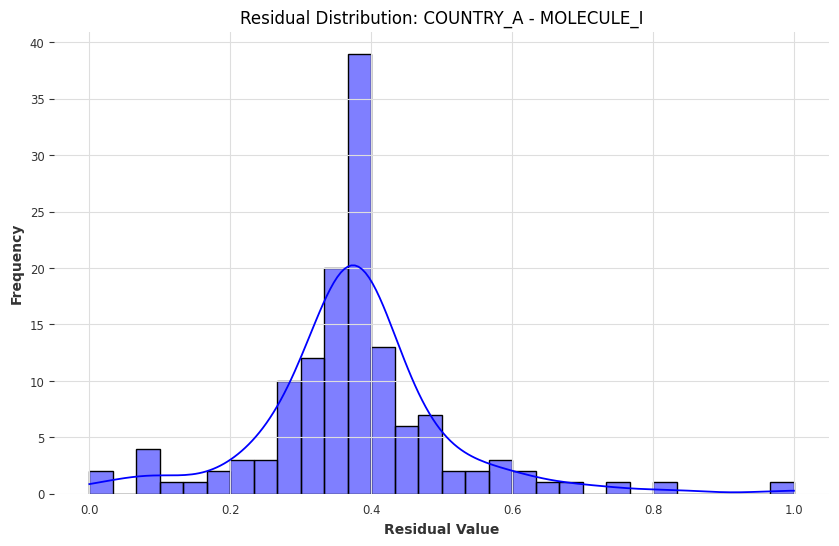

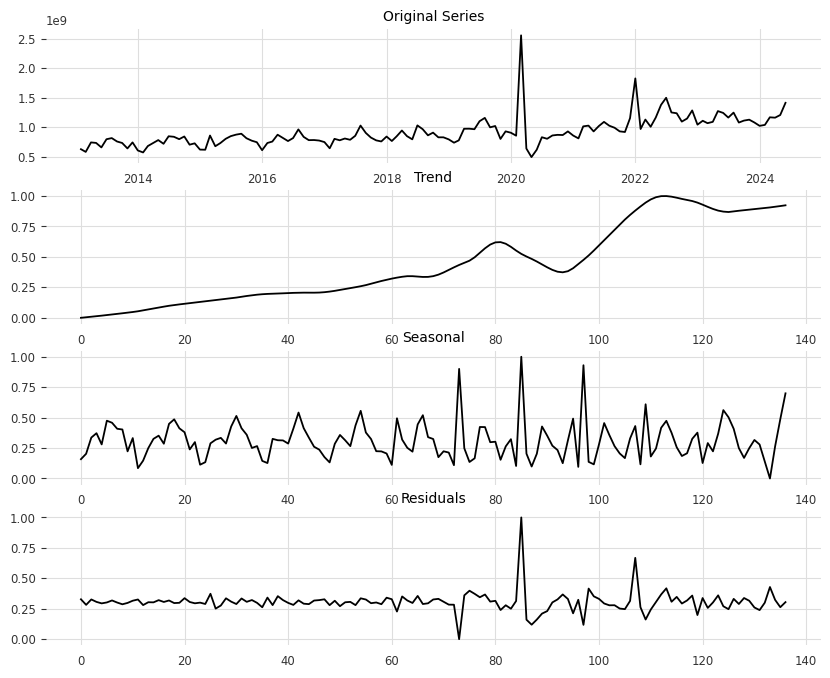

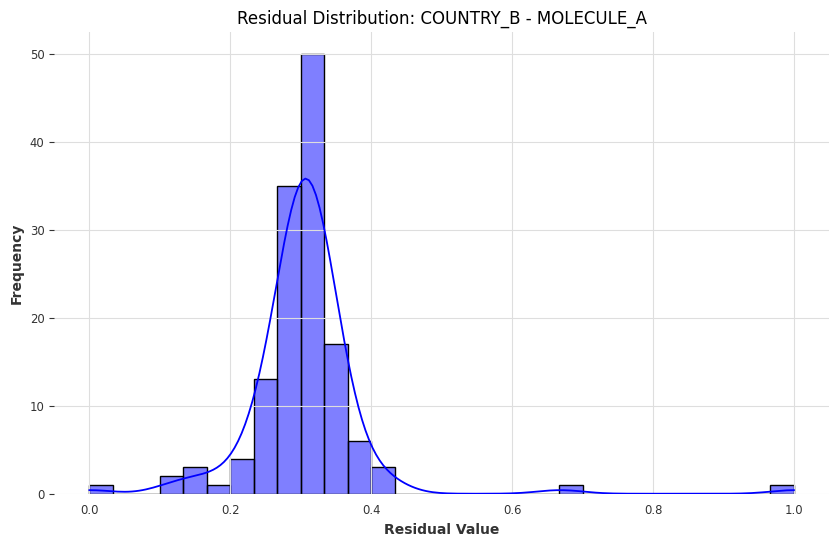

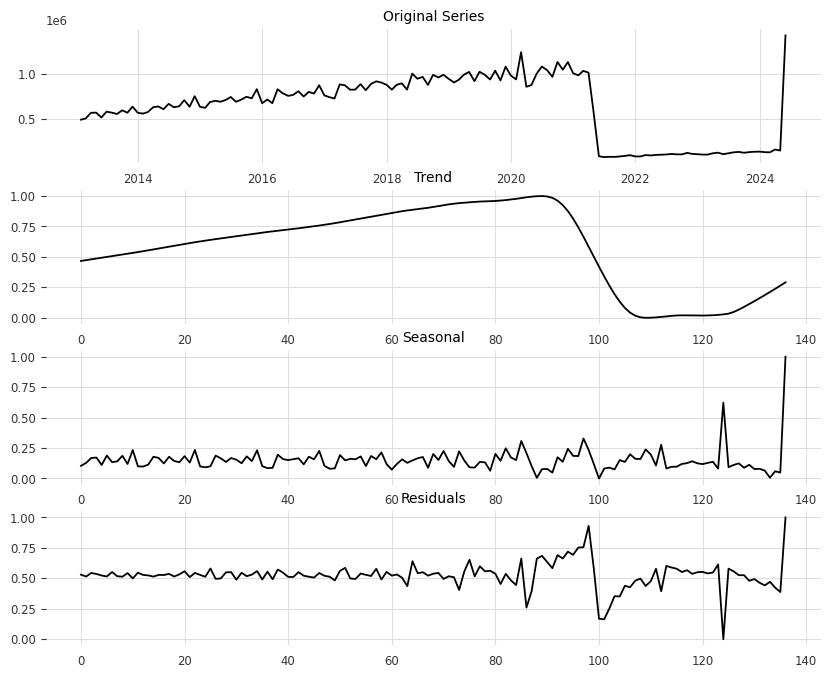

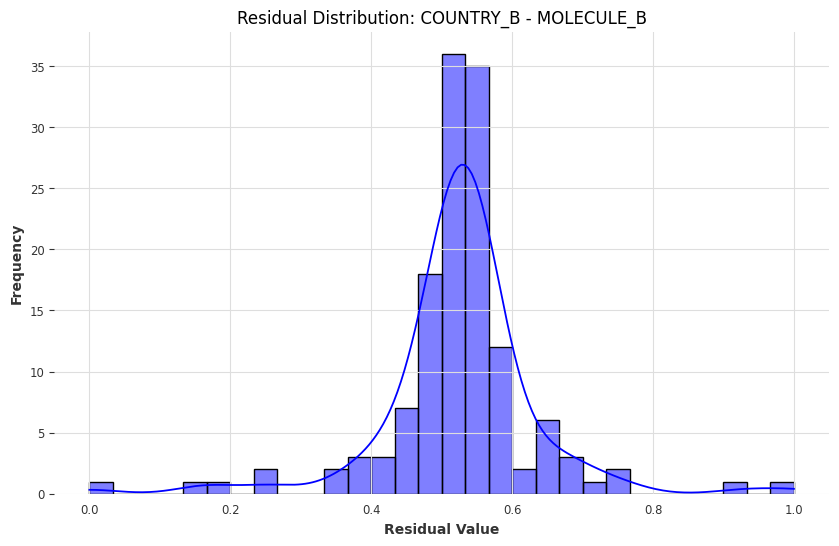

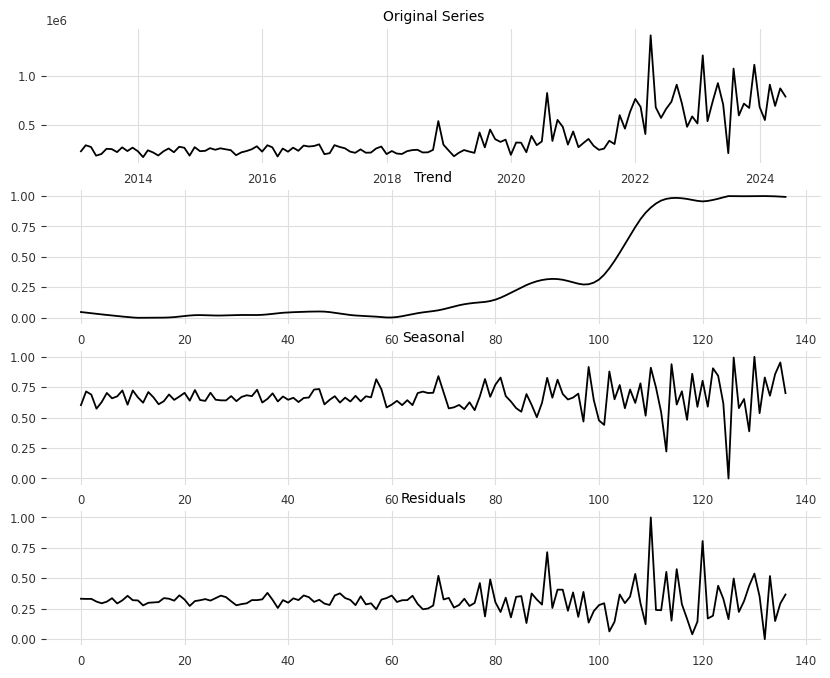

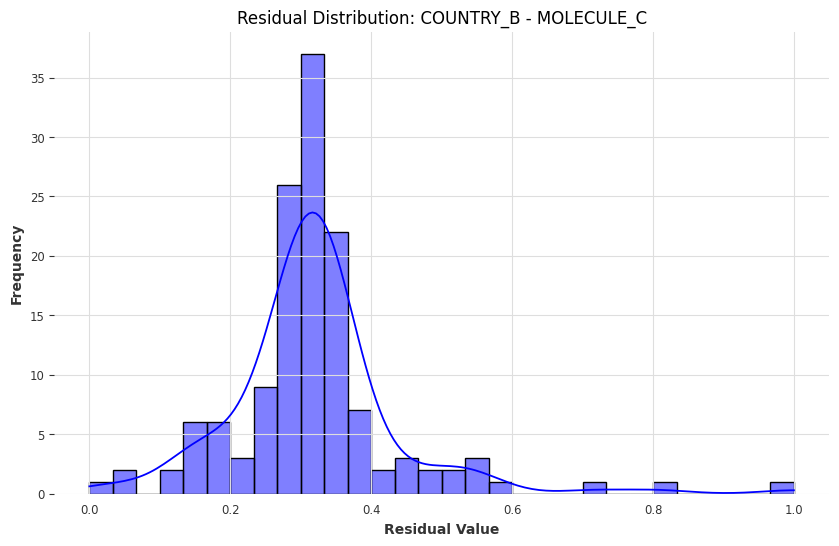

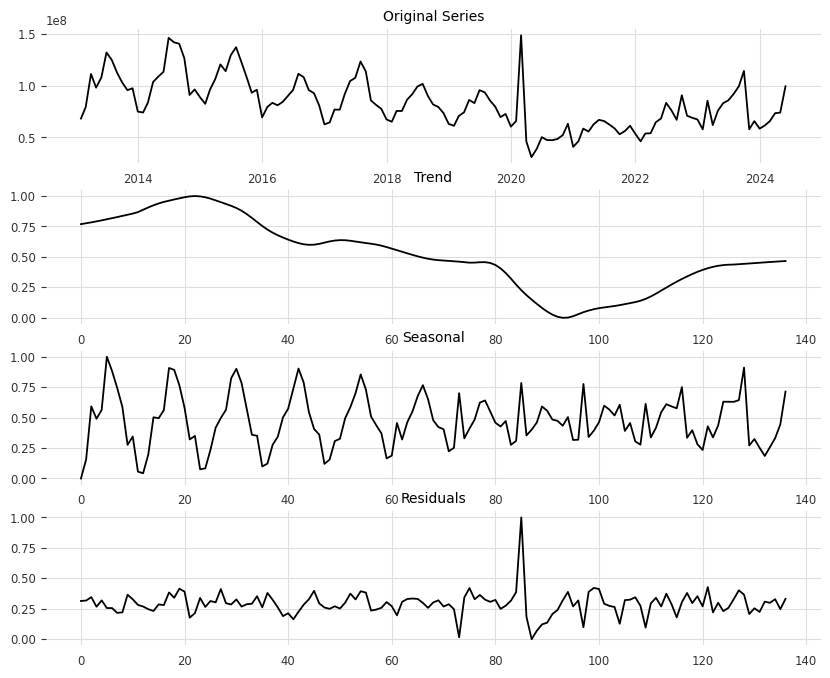

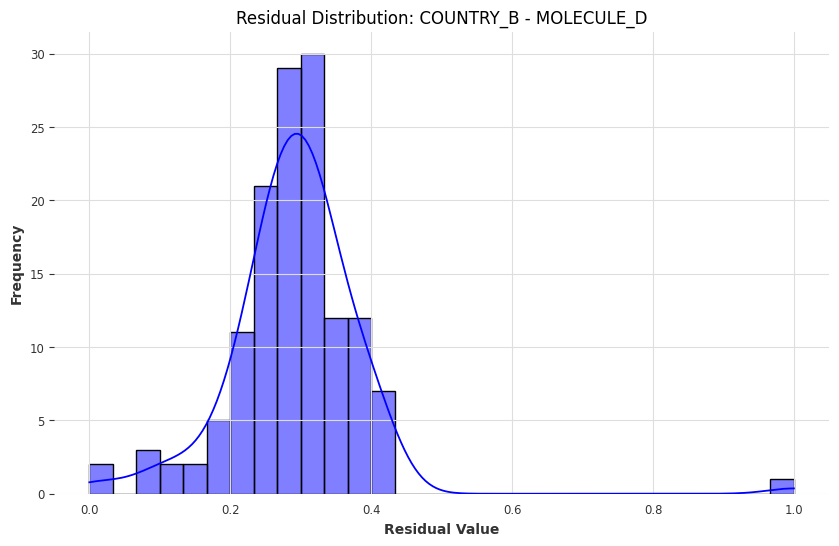

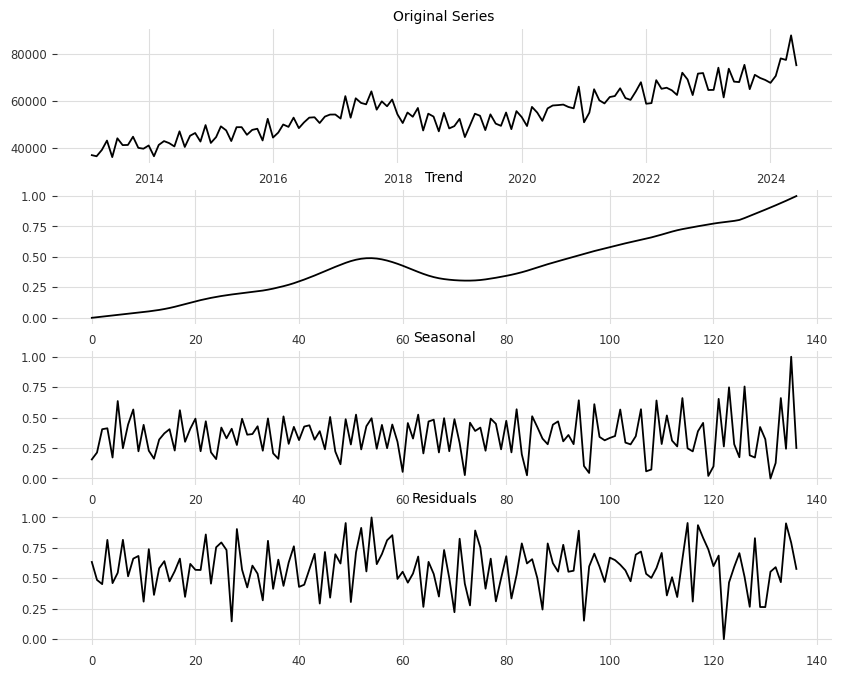

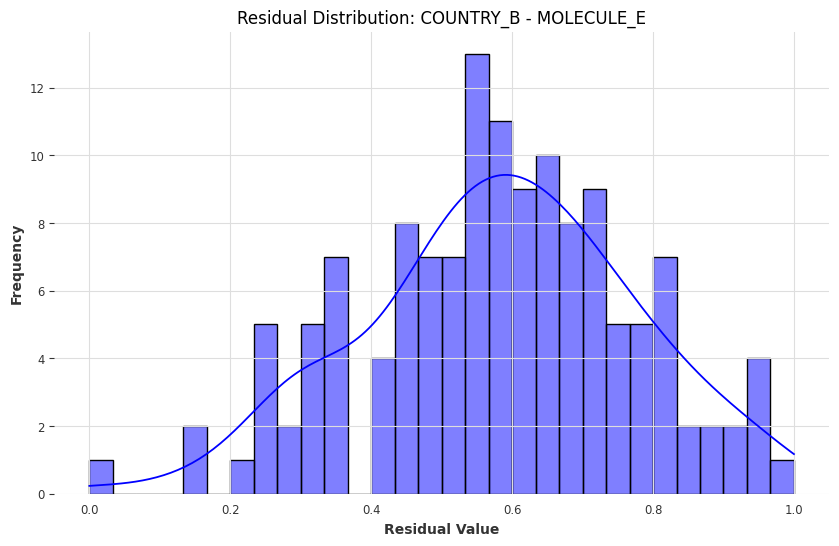

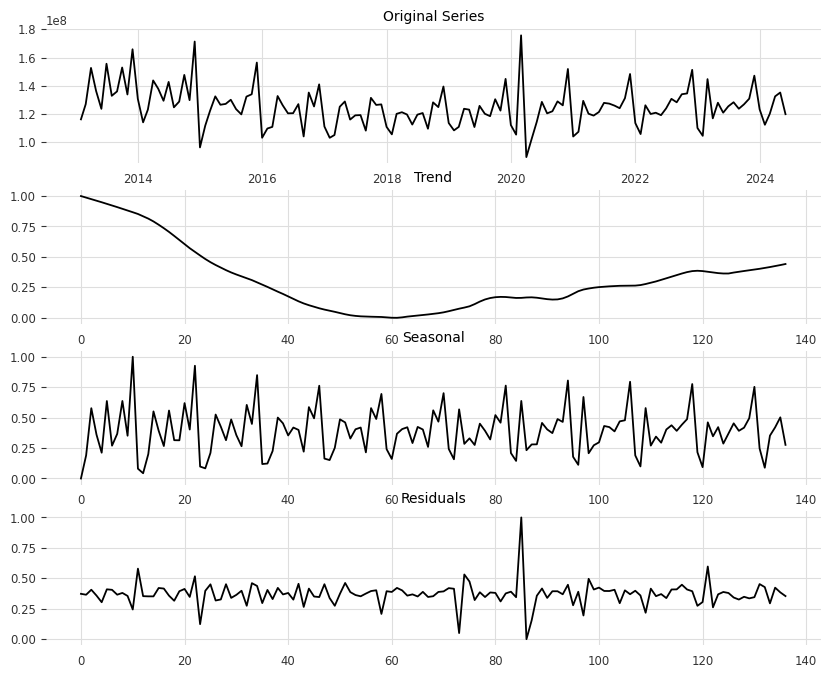

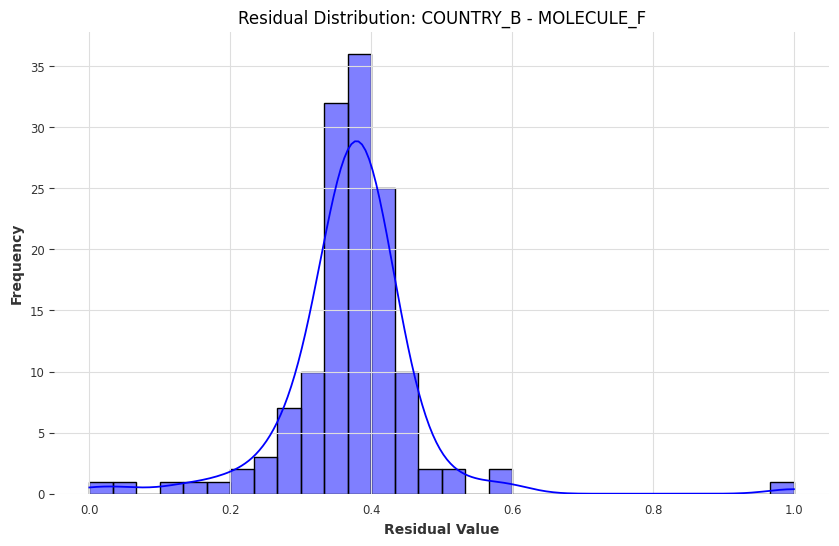

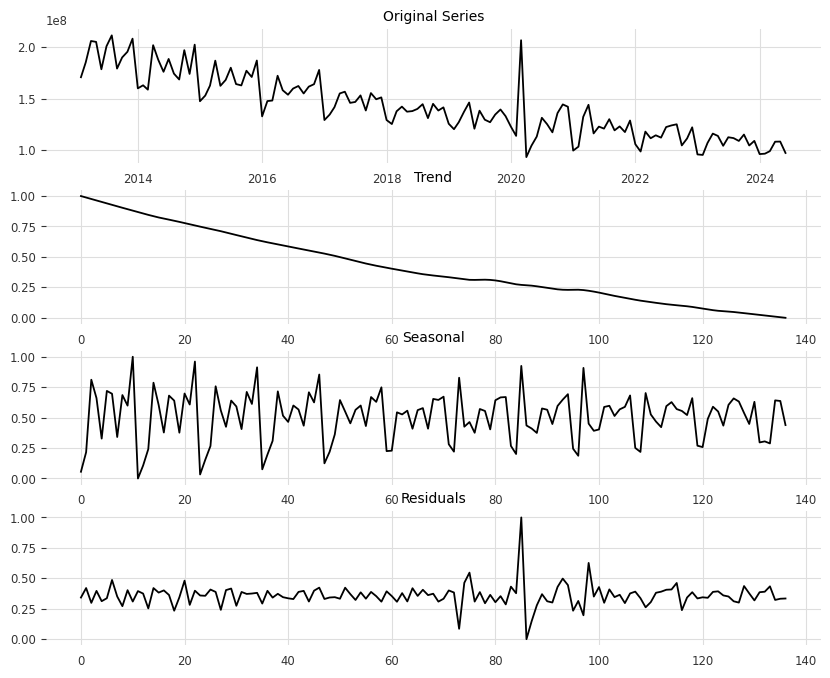

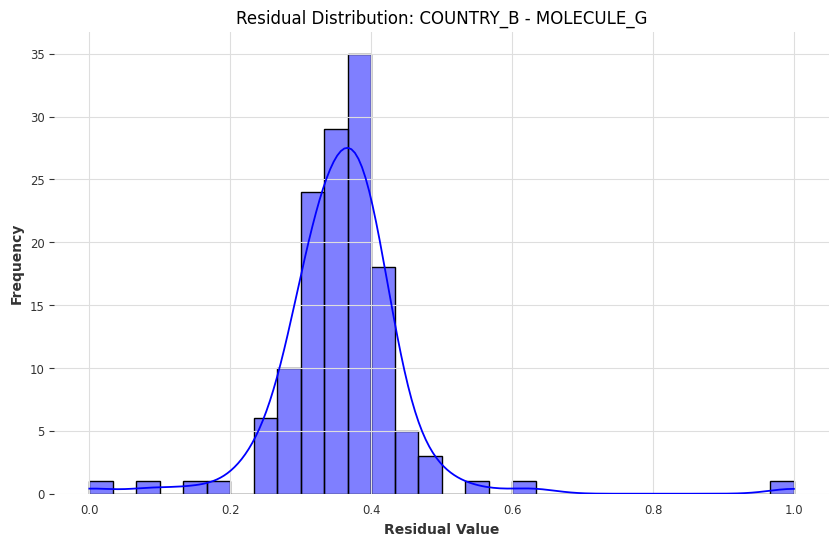

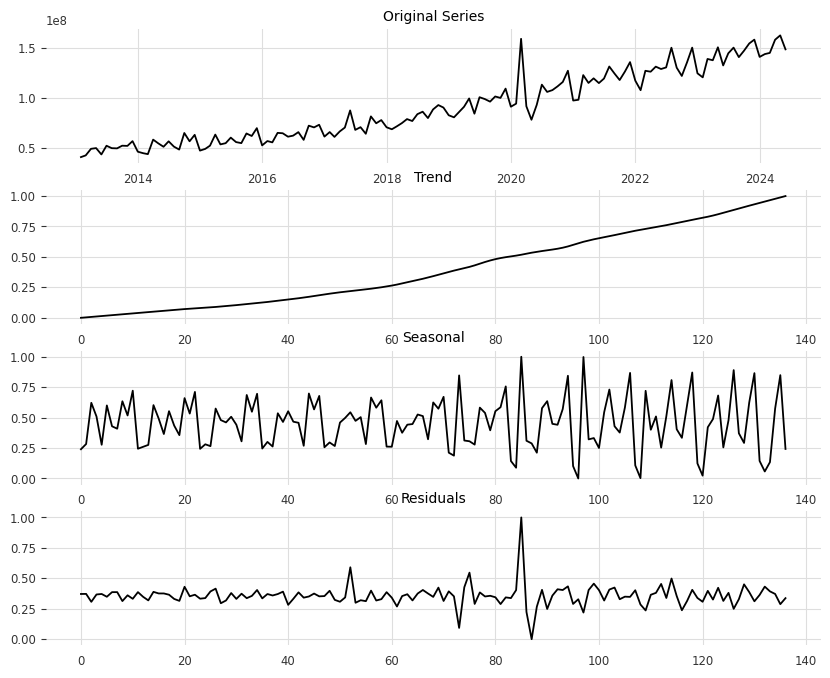

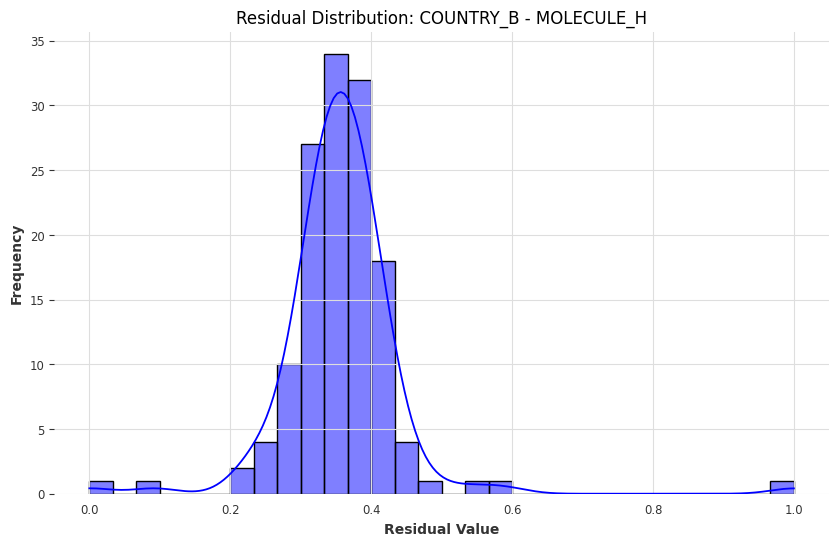

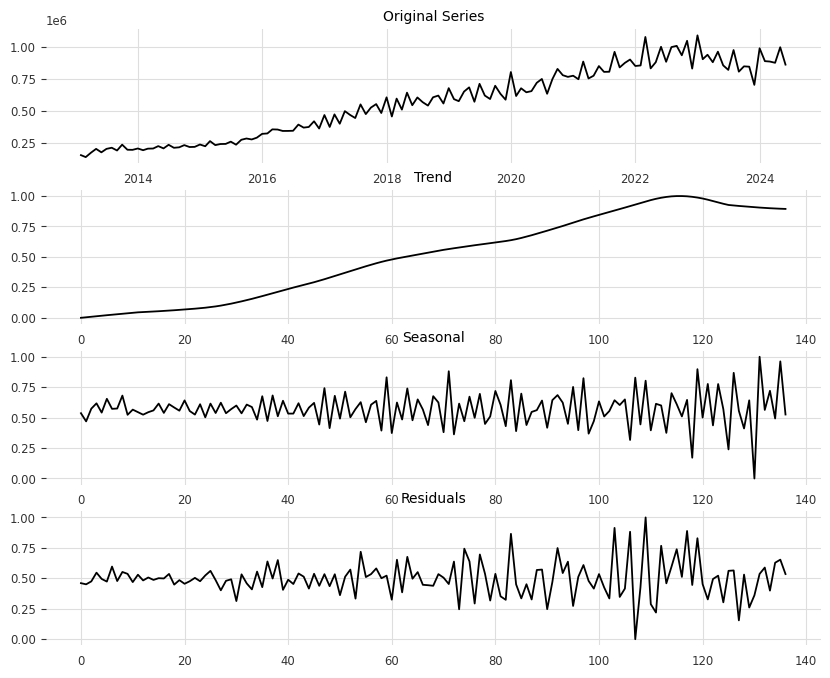

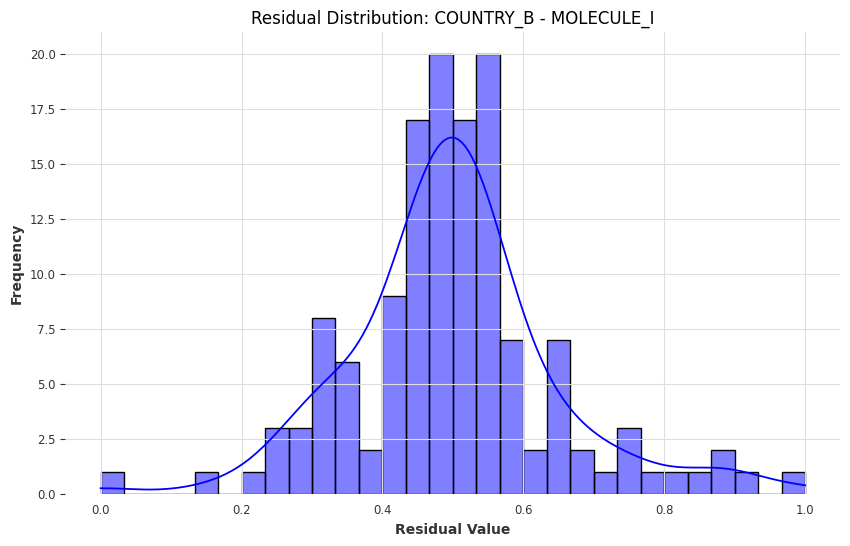

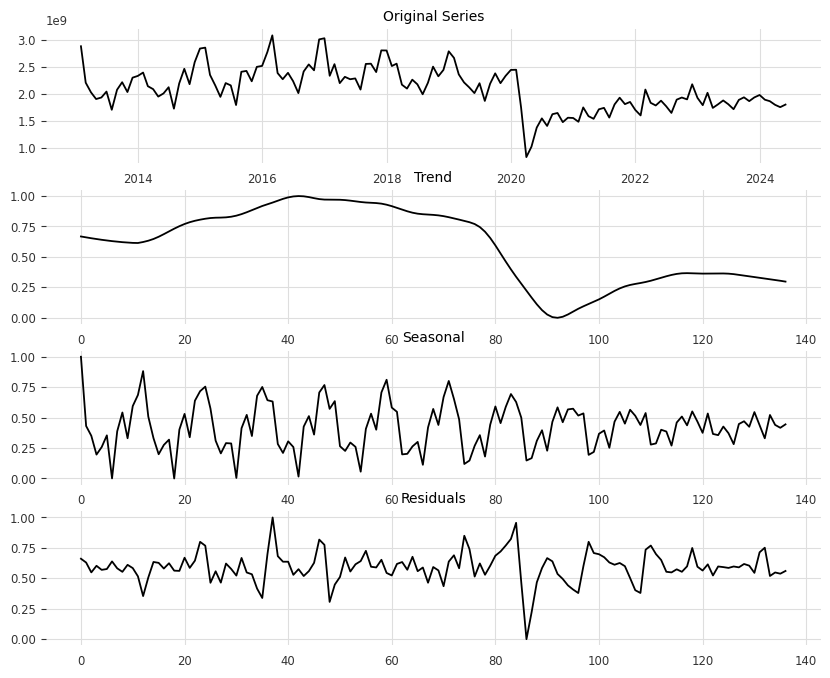

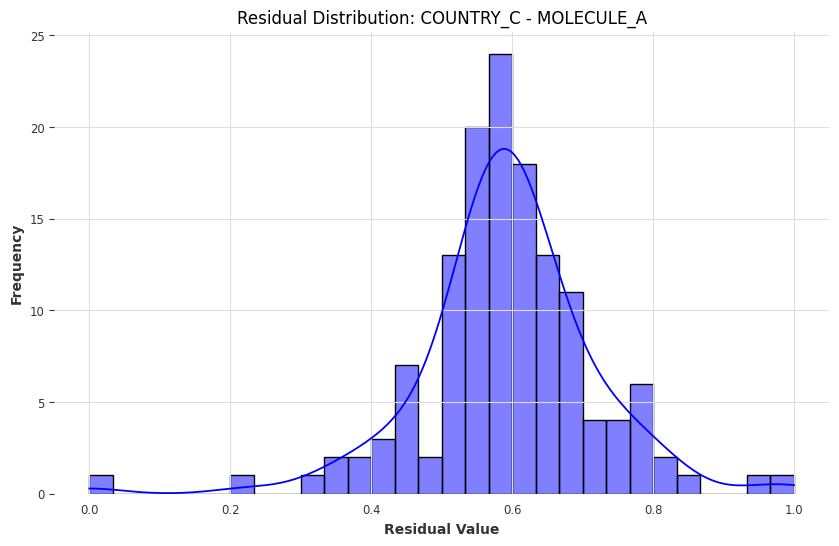

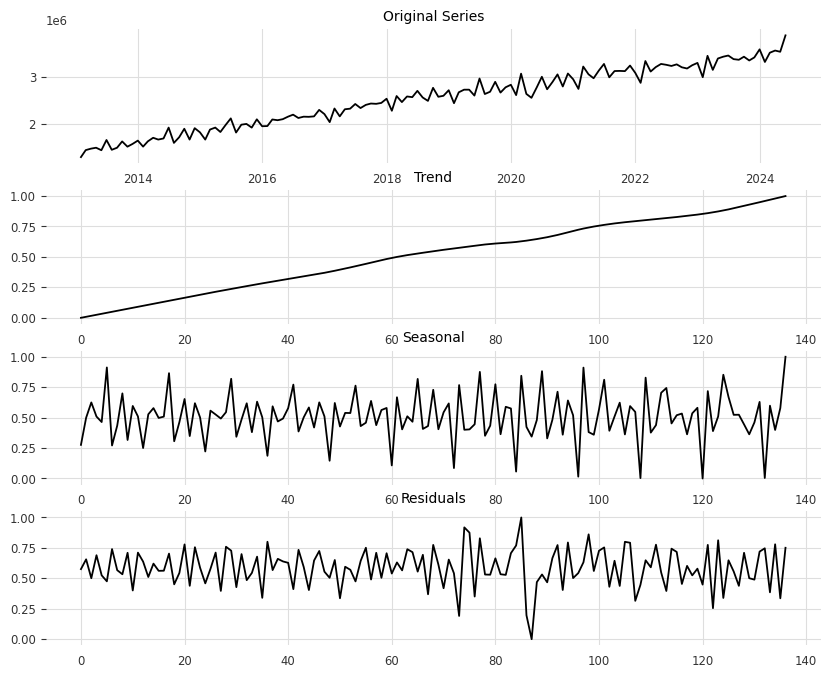

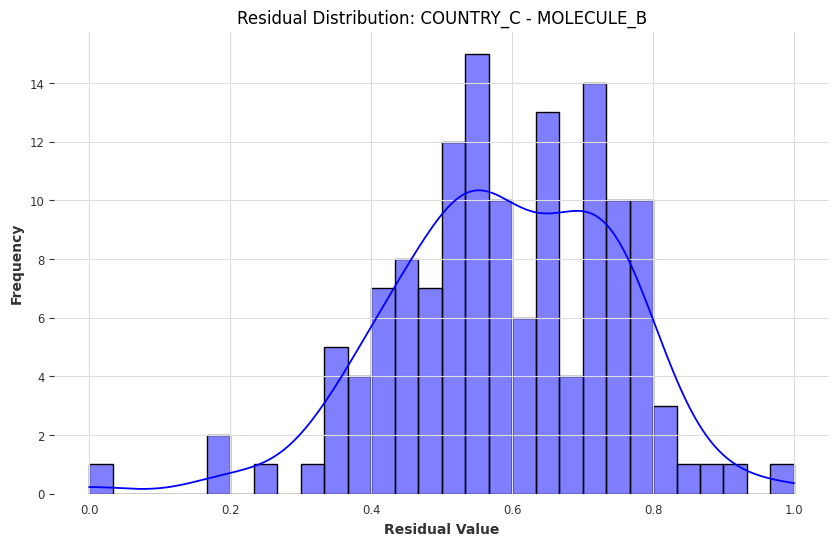

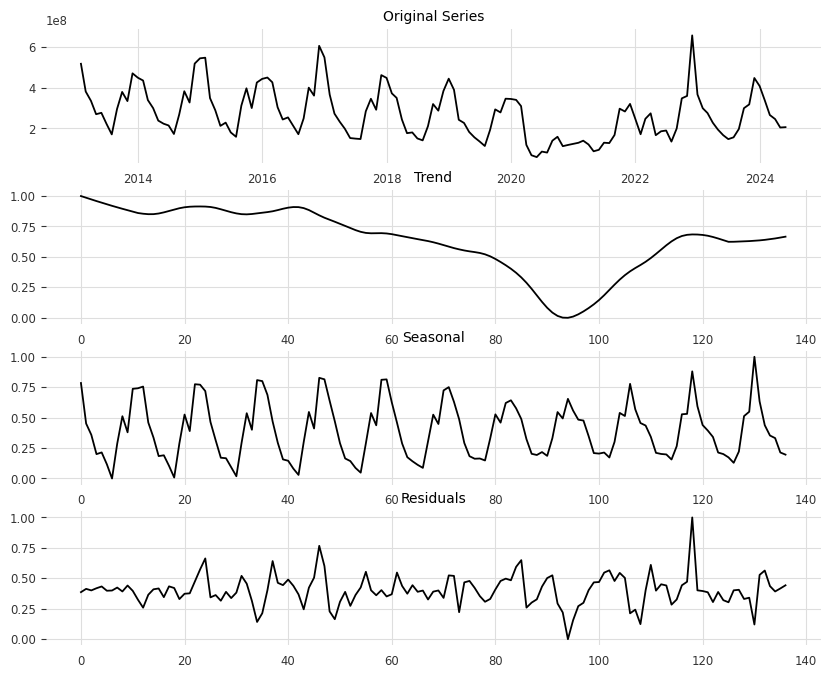

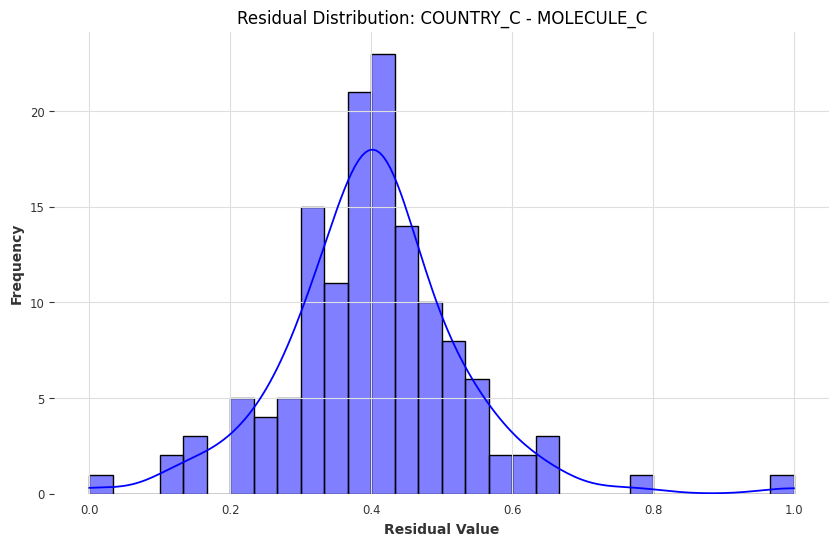

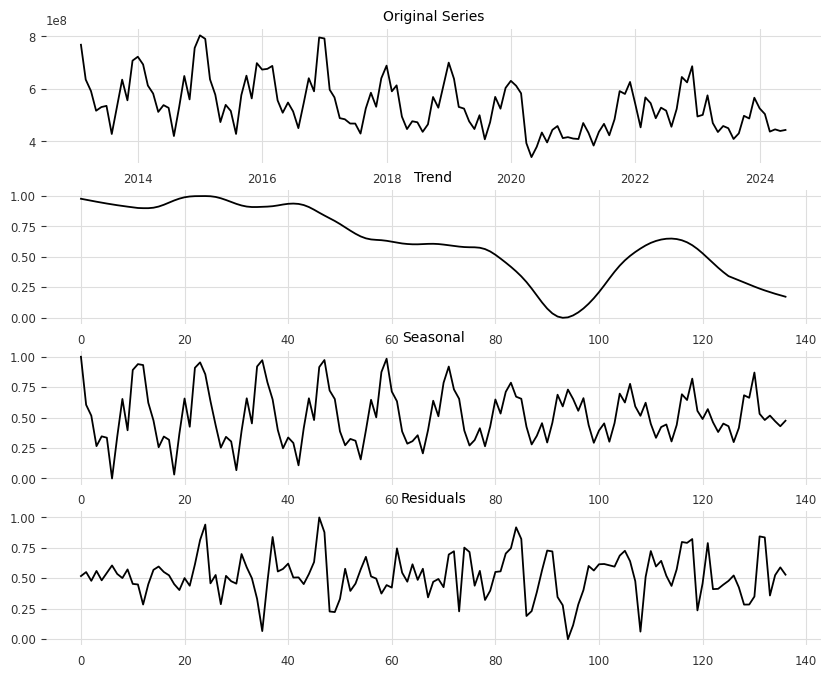

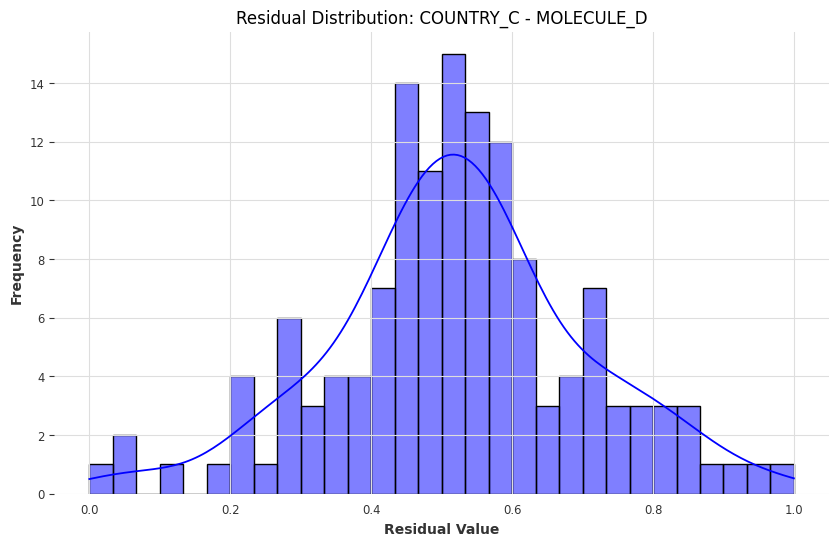

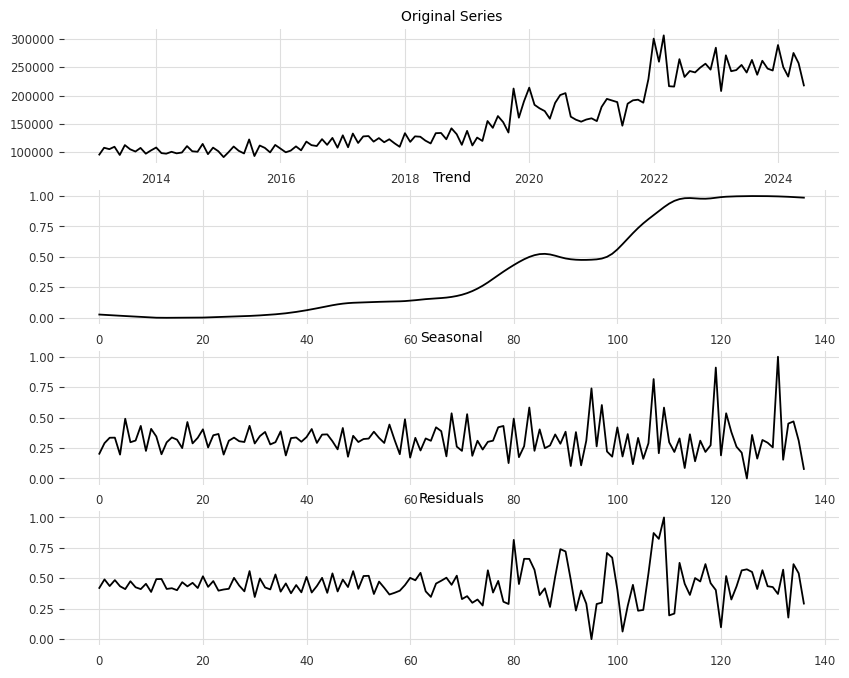

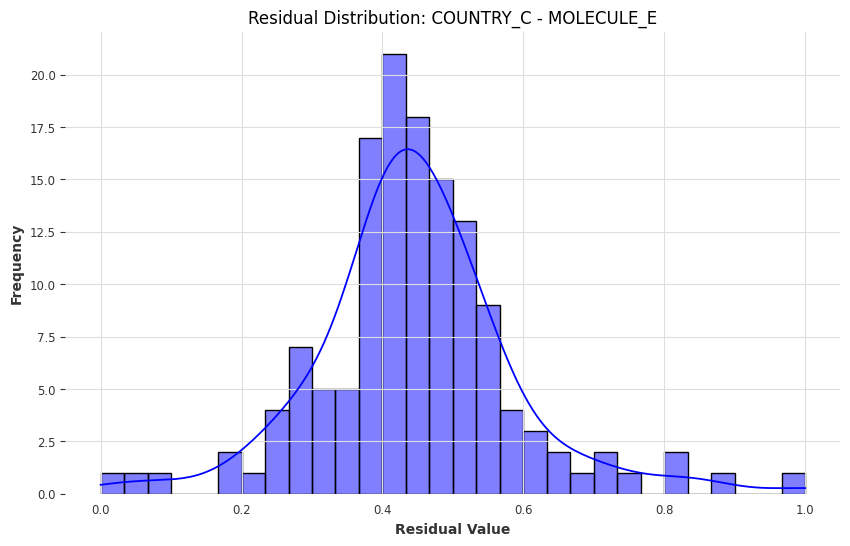

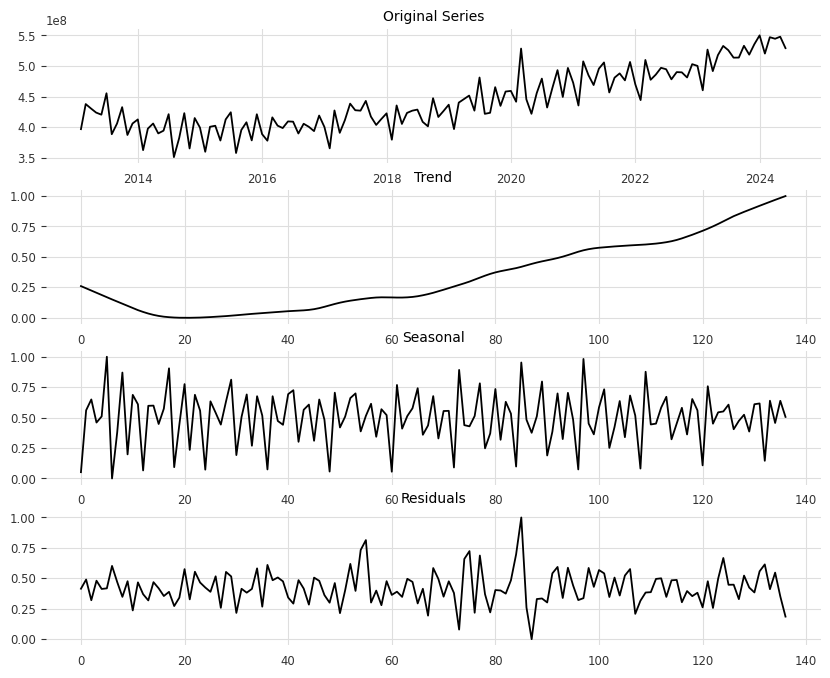

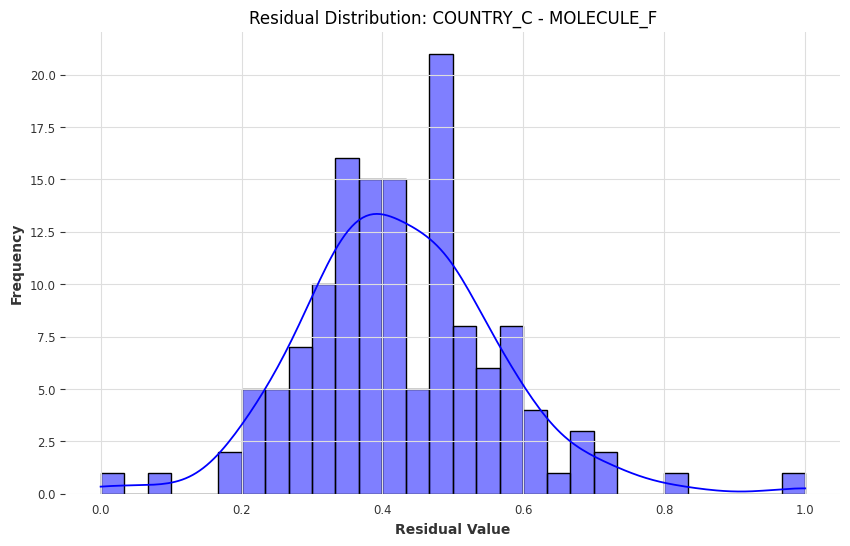

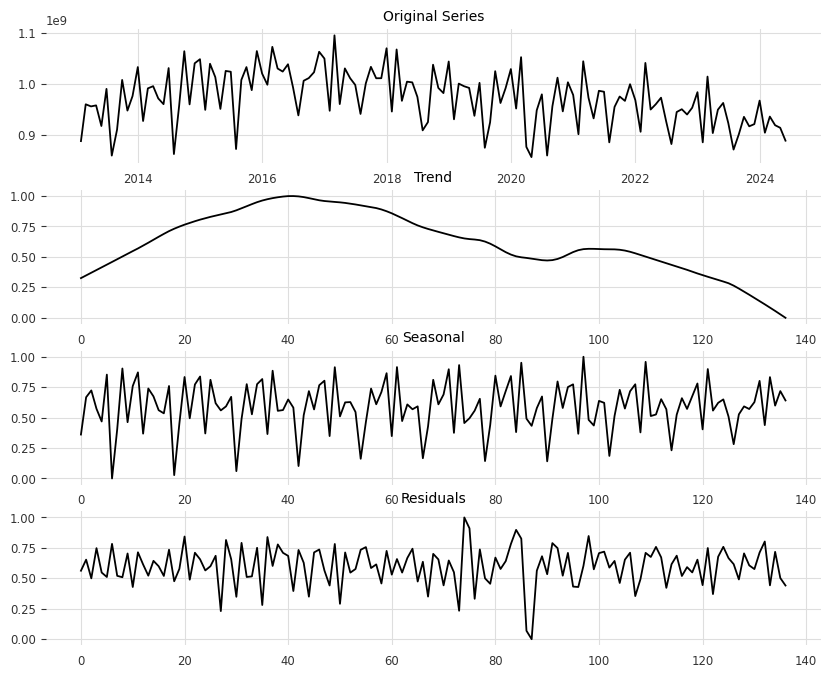

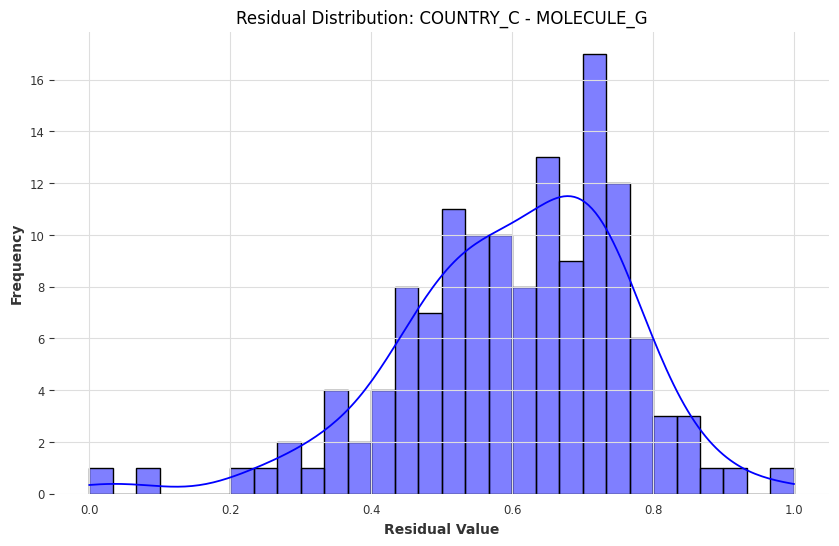

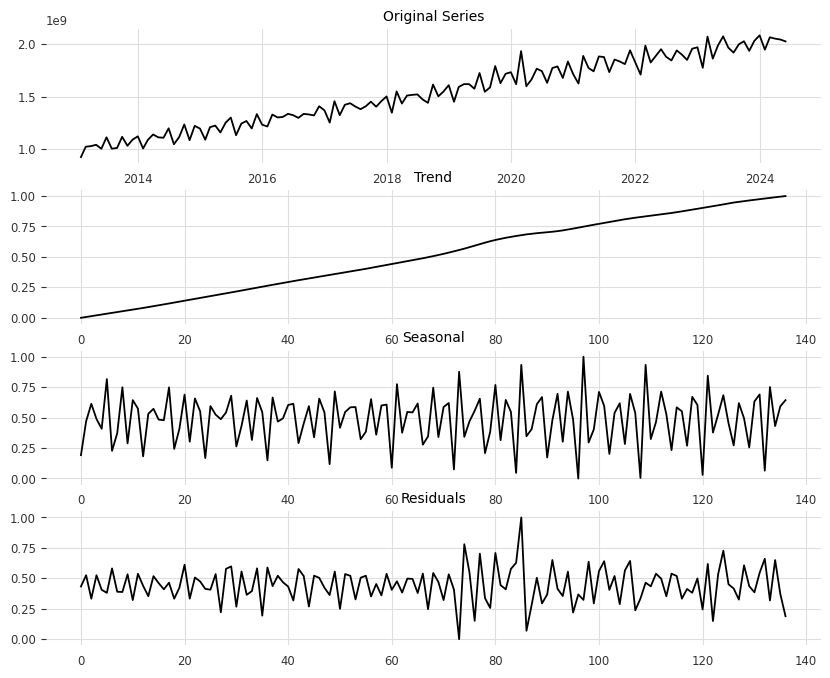

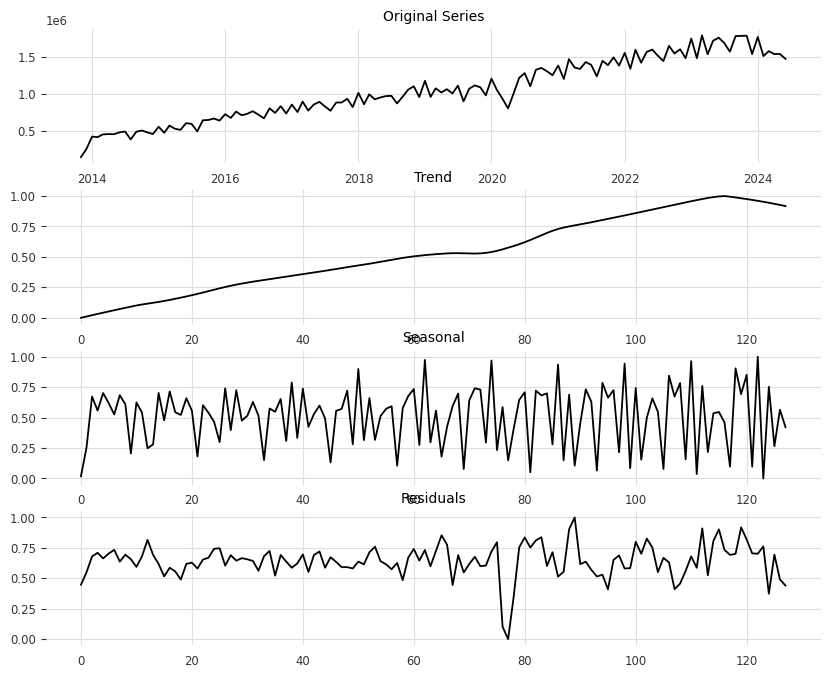

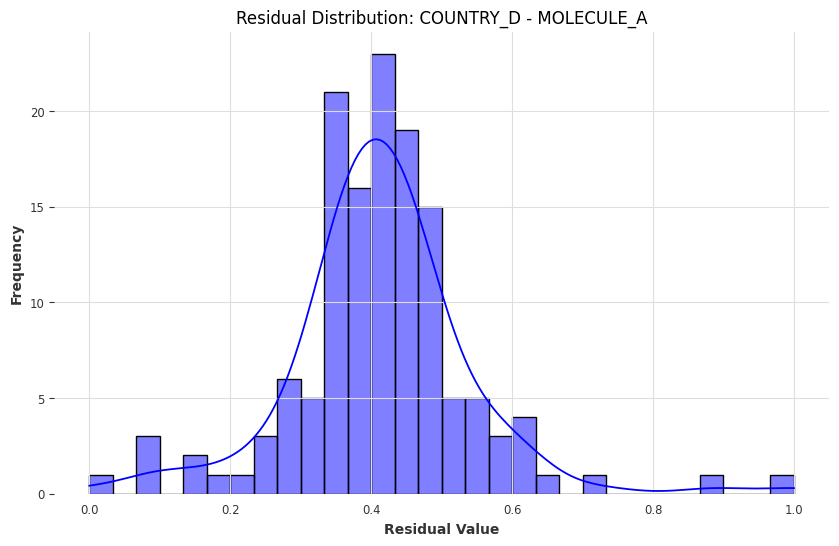

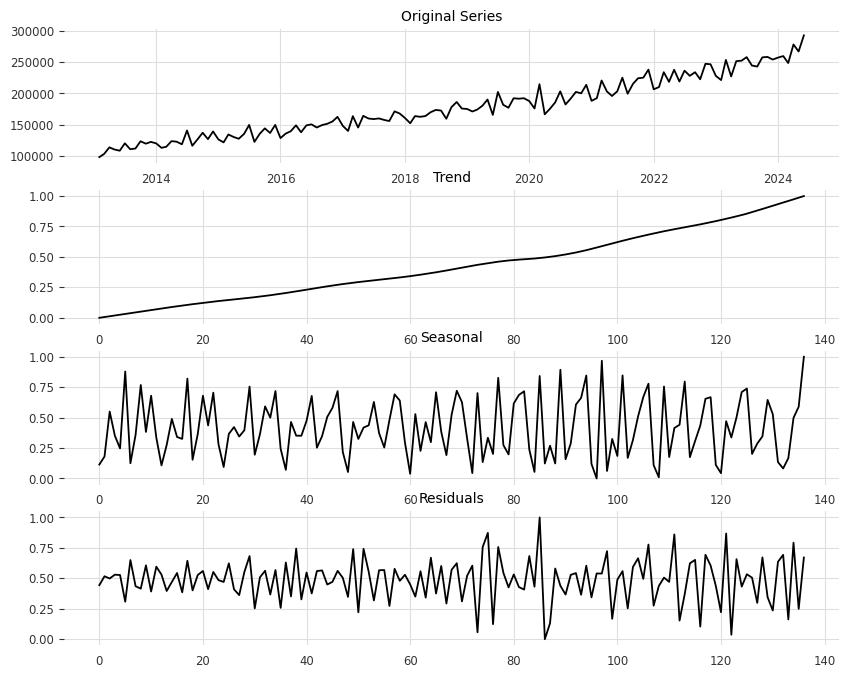

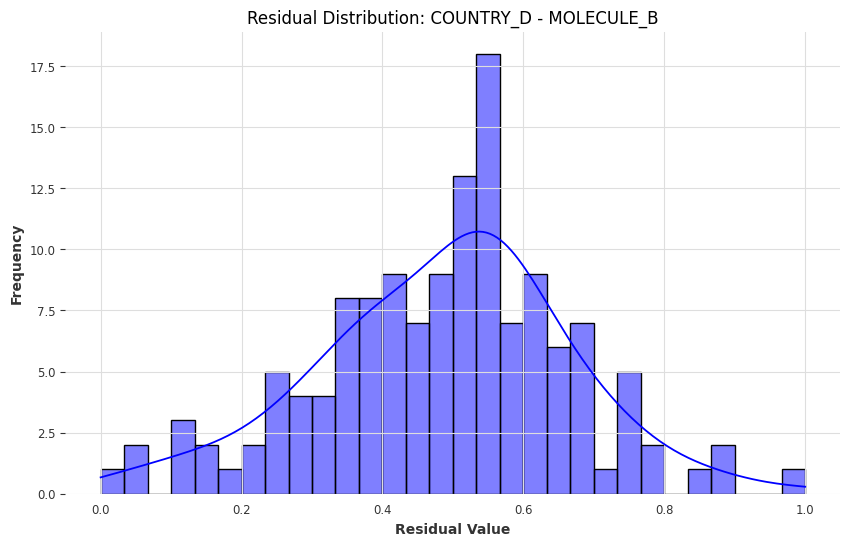

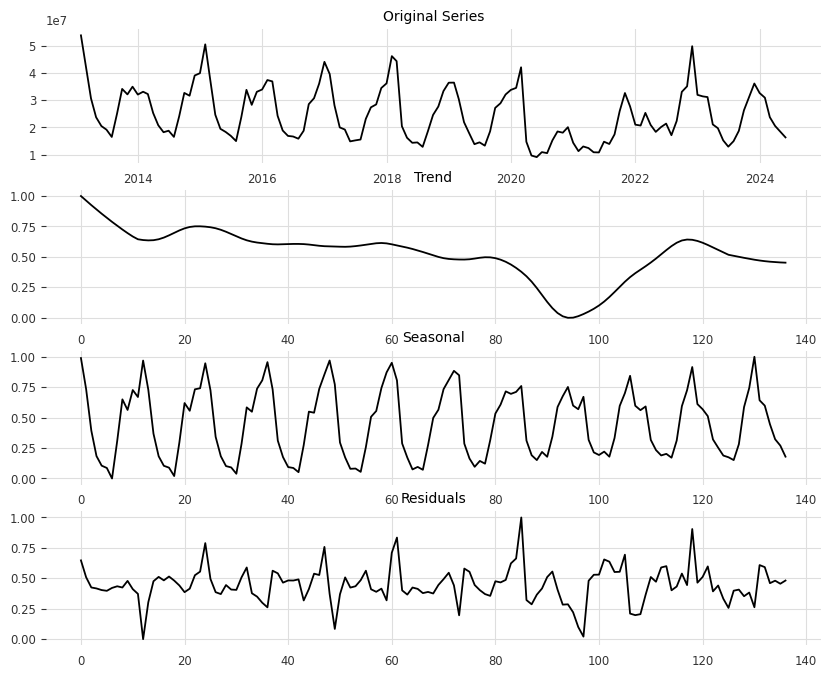

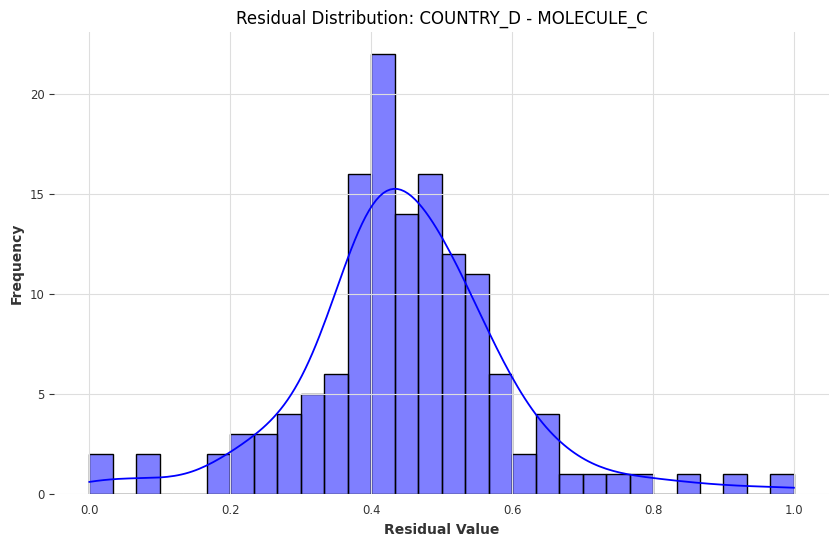

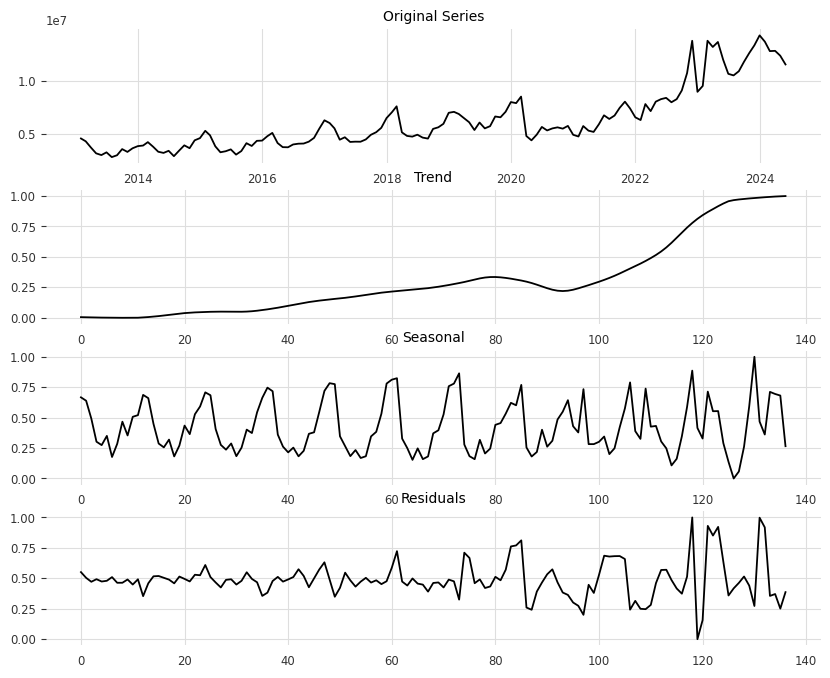

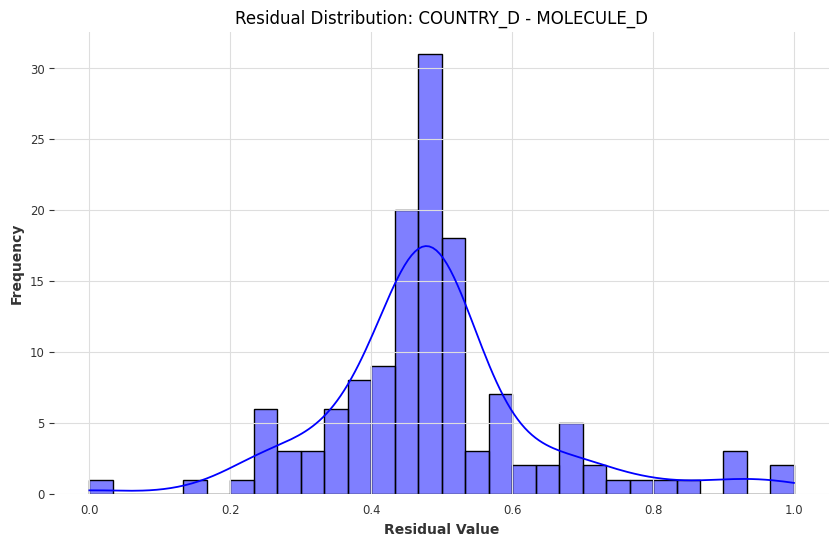

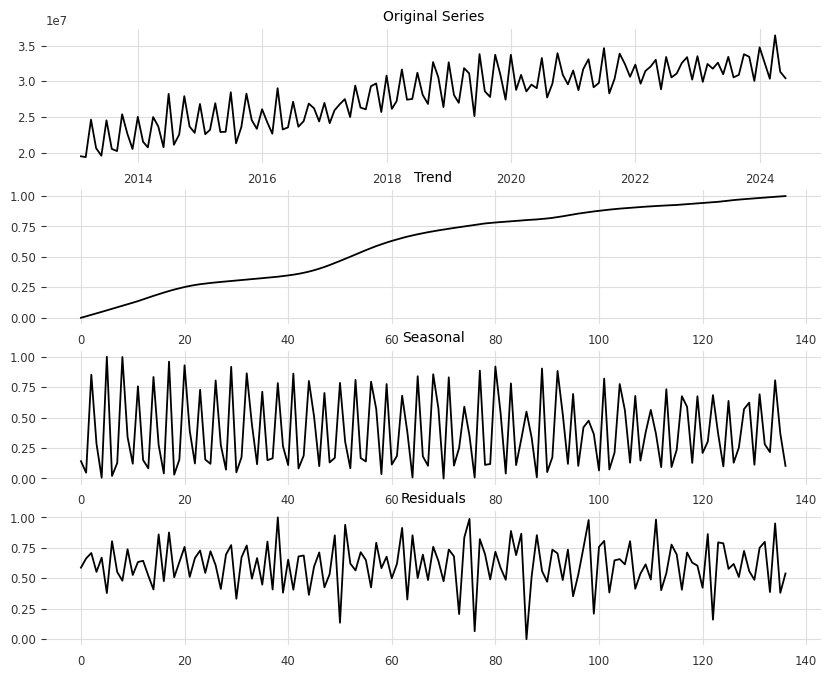

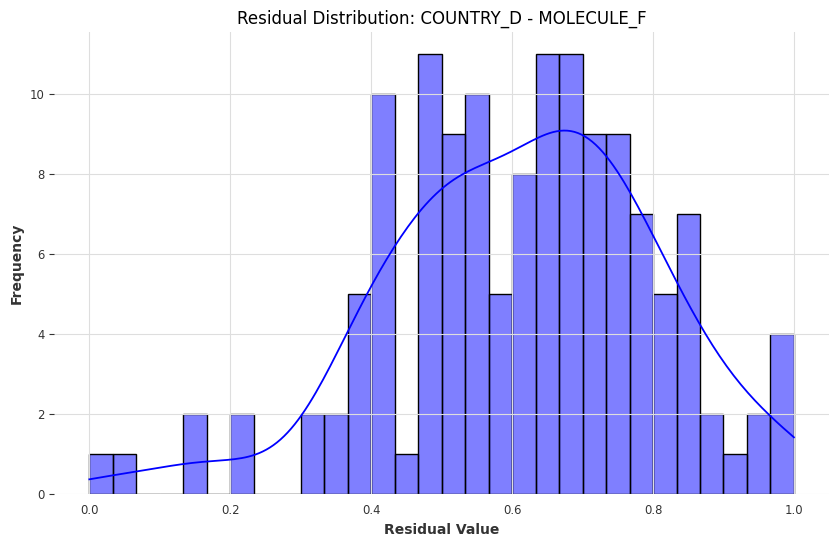

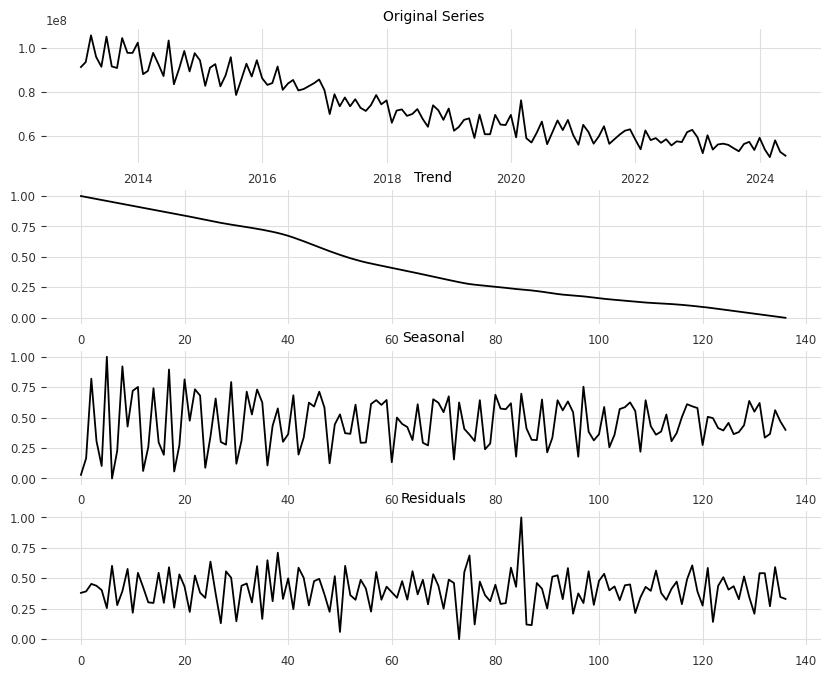

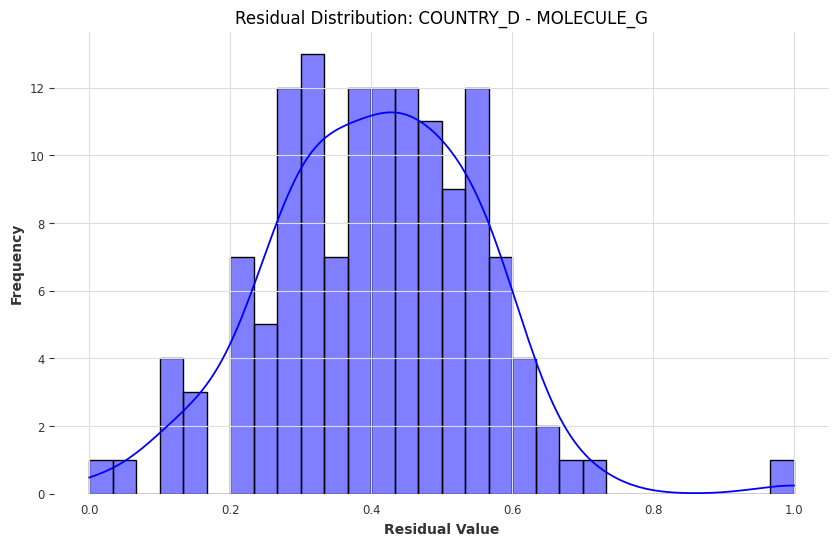

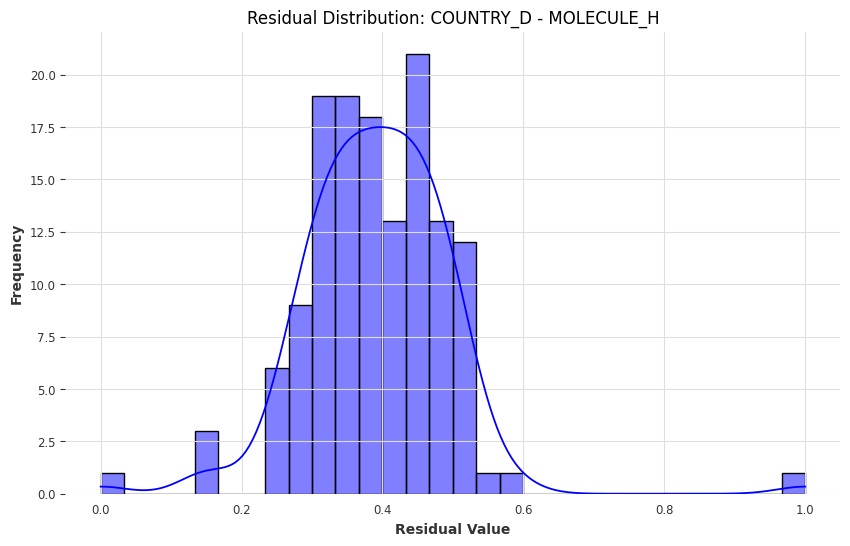

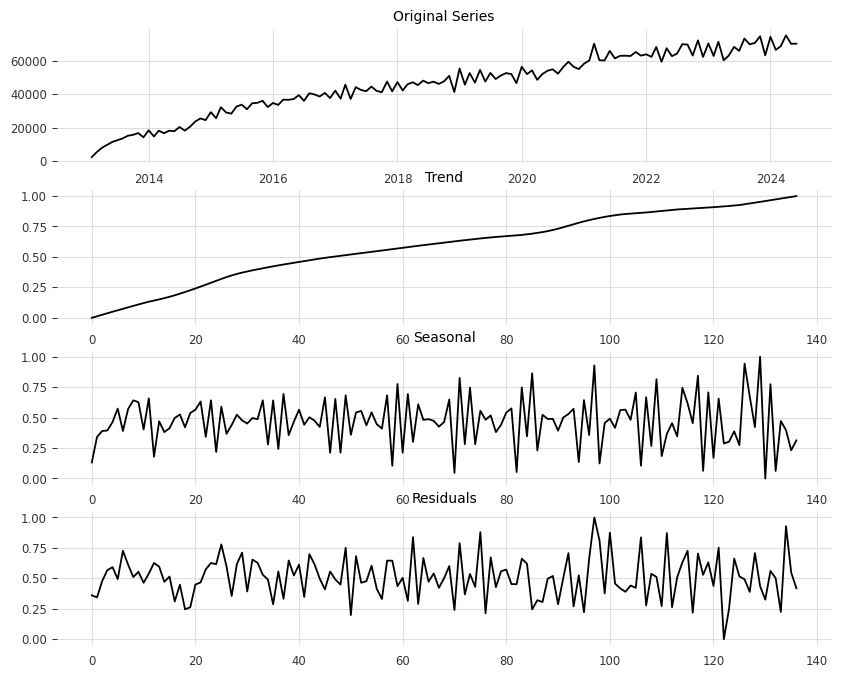

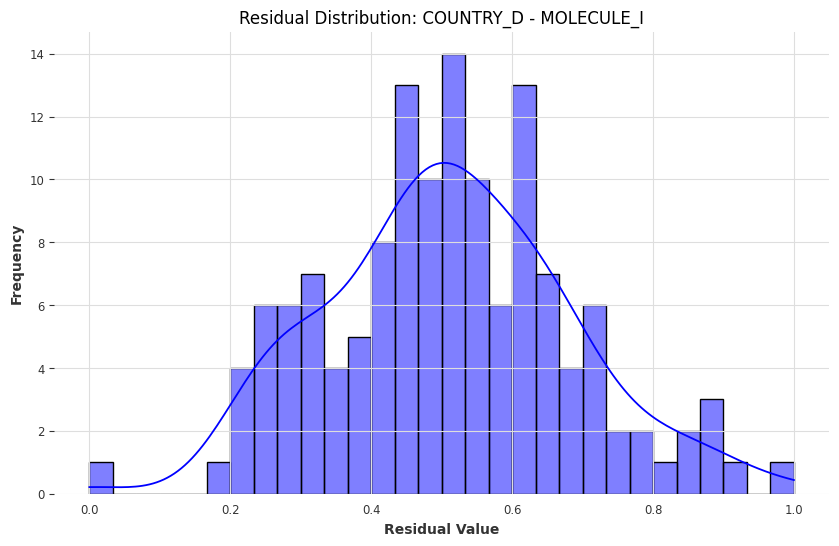

In [18]:
countries = ["COUNTRY_A", "COUNTRY_B", "COUNTRY_C", "COUNTRY_D"]
molecules = ["MOLECULE_A", "MOLECULE_B", "MOLECULE_C", "MOLECULE_D", "MOLECULE_E", "MOLECULE_F", "MOLECULE_G", "MOLECULE_H", "MOLECULE_I"]
for country in countries:
    for molecule in molecules:
        decomposition(country, molecule, True)

## Classification

In [19]:
from scipy.stats import linregress

def classify_trend(serie):
    x = np.arange(len(serie))
    y = np.array(serie)
    
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    if slope > 0 and r_value**2 > 0.5:  # Pendiente positiva y correlación fuerte
        return "upwards"
    elif slope < 0 and r_value**2 > 0.5:  # Pendiente negativa y correlación fuerte
        return "downwards"
    else:  
        return "stable"

In [52]:
def classify_seasonality(seasonal_component, resid):
    
    var_estational = np.var(seasonal_component)
    
    var_total = np.var(seasonal_component + resid)
    
    stationality_force = var_estational / var_total

    if stationality_force > 0.72:
        return "strong", stationality_force
    else:
        return "weak", stationality_force

In [53]:
def classify_noise(residuals, seasonal):
    
    var_resid = np.var(residuals)
    
    var_total = np.var(residuals + seasonal) 
    
    noise_prop = var_resid / var_total

    if noise_prop > 0.2:
        return "Noisy", noise_prop
    else:
        return "Not noisy", noise_prop

In [58]:
countries = ["COUNTRY_A", "COUNTRY_B", "COUNTRY_C", "COUNTRY_D"]
molecules = ["MOLECULE_A", "MOLECULE_B", "MOLECULE_C", "MOLECULE_D", "MOLECULE_E", "MOLECULE_F", "MOLECULE_G", "MOLECULE_H", "MOLECULE_I"]
classify = {}
for country in countries:
    for molecule in molecules:
        if f'{country}{molecule}' not in classify.keys(): classify[f'{country} - {molecule}'] = [] 
        serie = sales_data_molec[country][molecule]
        trend, seasonality, resid = decomposition(country, molecule, False)
        classify[f'{country} - {molecule}'].append(classify_trend(serie))
        classi, force = classify_seasonality(seasonality, resid)
        classify[f'{country} - {molecule}'].append(classi)
        classify[f'{country} - {molecule}'].append(force)
        classi, force = classify_seasonality(resid, seasonality)
        classify[f'{country} - {molecule}'].append(classi)
        classify[f'{country} - {molecule}'].append(force)

In [59]:
df = pd.DataFrame.from_dict(classify, orient='index', columns=['Trend', 'Seasonality_class', 'Seasonality_prop', 'Noise', 'Noise_prop'])
df.reset_index(inplace=True)
df.columns = ['Time Series', 'Trend', 'Seasonality_class', 'Seasonality_prop', 'Noise', 'Noise_prop']

print(df)


               Time Series      Trend Seasonality_class  Seasonality_prop  \
0   COUNTRY_A - MOLECULE_A     stable            strong          0.841537   
1   COUNTRY_A - MOLECULE_B    upwards            strong          0.742350   
2   COUNTRY_A - MOLECULE_C     stable              weak          0.708933   
3   COUNTRY_A - MOLECULE_D     stable              weak          0.659936   
4   COUNTRY_A - MOLECULE_E     stable            strong          0.737112   
5   COUNTRY_A - MOLECULE_F    upwards            strong          0.771512   
6   COUNTRY_A - MOLECULE_G     stable            strong          0.776146   
7   COUNTRY_A - MOLECULE_H    upwards            strong          0.841681   
8   COUNTRY_A - MOLECULE_I    upwards            strong          0.745202   
9   COUNTRY_B - MOLECULE_A     stable            strong          0.916397   
10  COUNTRY_B - MOLECULE_B     stable            strong          0.797656   
11  COUNTRY_B - MOLECULE_C     stable            strong          0.879013   

## Clustering

In [61]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

In [62]:
encoder = LabelEncoder()
df['Trend_encoded'] = encoder.fit_transform(df['Trend'])


X = df[['Trend_encoded', 'Seasonality_prop', 'Noise_prop']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

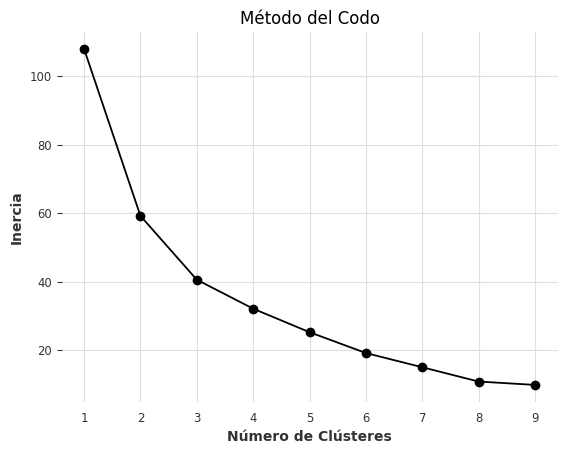

In [63]:
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 10), inertias, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.show()


In [65]:
# Paso 3: Aplicar K-Means
kmeans = KMeans(n_clusters=9, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualización
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df['Trend_encoded'], 
    y=df['Seasonality_prop'], 
    hue=df['Cluster'], 
    palette='Set1'
)
plt.title('Clustering of Time Series')
plt.xlabel('Trend (encoded)')
plt.ylabel('Seasonality (encoded)')
plt.show()

# Mostrar los clusters asignados
print(df)

               Time Series      Trend Seasonality_class  Seasonality_prop  \
0   COUNTRY_A - MOLECULE_A     stable            strong          0.841537   
1   COUNTRY_A - MOLECULE_B    upwards            strong          0.742350   
2   COUNTRY_A - MOLECULE_C     stable              weak          0.708933   
3   COUNTRY_A - MOLECULE_D     stable              weak          0.659936   
4   COUNTRY_A - MOLECULE_E     stable            strong          0.737112   
5   COUNTRY_A - MOLECULE_F    upwards            strong          0.771512   
6   COUNTRY_A - MOLECULE_G     stable            strong          0.776146   
7   COUNTRY_A - MOLECULE_H    upwards            strong          0.841681   
8   COUNTRY_A - MOLECULE_I    upwards            strong          0.745202   
9   COUNTRY_B - MOLECULE_A     stable            strong          0.916397   
10  COUNTRY_B - MOLECULE_B     stable            strong          0.797656   
11  COUNTRY_B - MOLECULE_C     stable            strong          0.879013   

In [67]:
print(df[['Time Series', 'Trend', 'Seasonality_prop', 'Noise_prop', 'Cluster']])

               Time Series      Trend  Seasonality_prop  Noise_prop  Cluster
0   COUNTRY_A - MOLECULE_A     stable          0.841537    0.098388        3
1   COUNTRY_A - MOLECULE_B    upwards          0.742350    0.203948        4
2   COUNTRY_A - MOLECULE_C     stable          0.708933    0.281728        5
3   COUNTRY_A - MOLECULE_D     stable          0.659936    0.205418        5
4   COUNTRY_A - MOLECULE_E     stable          0.737112    0.221377        2
5   COUNTRY_A - MOLECULE_F    upwards          0.771512    0.215035        4
6   COUNTRY_A - MOLECULE_G     stable          0.776146    0.149324        2
7   COUNTRY_A - MOLECULE_H    upwards          0.841681    0.130914        1
8   COUNTRY_A - MOLECULE_I    upwards          0.745202    0.124310        8
9   COUNTRY_B - MOLECULE_A     stable          0.916397    0.070472        3
10  COUNTRY_B - MOLECULE_B     stable          0.797656    0.090122        3
11  COUNTRY_B - MOLECULE_C     stable          0.879013    0.092349        3

In [72]:
df_grouped = df.groupby("Cluster")
df_grouped.head()

Time Series      Trend Seasonality_class  Seasonality_prop  \
0   COUNTRY_A - MOLECULE_A     stable            strong          0.841537   
1   COUNTRY_A - MOLECULE_B    upwards            strong          0.742350   
2   COUNTRY_A - MOLECULE_C     stable              weak          0.708933   
3   COUNTRY_A - MOLECULE_D     stable              weak          0.659936   
4   COUNTRY_A - MOLECULE_E     stable            strong          0.737112   
5   COUNTRY_A - MOLECULE_F    upwards            strong          0.771512   
6   COUNTRY_A - MOLECULE_G     stable            strong          0.776146   
7   COUNTRY_A - MOLECULE_H    upwards            strong          0.841681   
8   COUNTRY_A - MOLECULE_I    upwards            strong          0.745202   
9   COUNTRY_B - MOLECULE_A     stable            strong          0.916397   
10  COUNTRY_B - MOLECULE_B     stable            strong          0.797656   
11  COUNTRY_B - MOLECULE_C     stable            strong          0.879013   
12  COUNTRY_B - MOLECULE_D     stable            strong          0.859057   
13  COUNTRY_B - MOLECULE_E    upwards              weak          0.626493   
15  COUNTRY_B - MOLECULE_G  downwards            strong          0.906590   
16  COUNTRY_B - MOLECULE_H    upwards            strong          0.924713   
17  COUNTRY_B - MOLECULE_I    upwards            strong          0.817594   
18  COUNTRY_C - MOLECULE_A     stable            strong          0.800128   
19  COUNTRY_C - MOLECULE_B    upwards            strong          0.769368   
20  COUNTRY_C - MOLECULE_C     stable            strong          0.753529   
21  COUNTRY_C - MOLECULE_D     stable              weak          0.660776   
22  COUNTRY_C - MOLECULE_E    upwards            strong          0.842227   
23  COUNTRY_C - MOLECULE_F    upwards            strong          0.794429   
24  COUNTRY_C - MOLECULE_G     stable              weak          0.696262   
25  COUNTRY_C - MOLECULE_H    upwards            strong          0.809987   
26  COUNTRY_C - MOLECULE_I     stable            strong          0.786480   
28  COUNTRY_D - MOLECULE_B    upwards              weak          0.711019   
29  COUNTRY_D - MOLECULE_C     stable              weak          0.582139   
32  COUNTRY_D - MOLECULE_F    upwards              weak          0.716755   
33  COUNTRY_D - MOLECULE_G  downwards            strong          0.811815   
34  COUNTRY_D - MOLECULE_H    upwards            strong          0.891057   
35  COUNTRY_D - MOLECULE_I    upwards            strong          0.720007   

   Noise  Noise_prop  Trend_encoded  Cluster  
0   weak    0.098388              1        3  
1   weak    0.203948              2        4  
2   weak    0.281728              1        5  
3   weak    0.205418              1        5  
4   weak    0.221377              1        2  
5   weak    0.215035              2        4  
6   weak    0.149324              1        2  
7   weak    0.130914              2        1  
8   weak    0.124310              2        8  
9   weak    0.070472              1        3  
10  weak    0.090122              1        3  
11  weak    0.092349              1        3  
12  weak    0.101611              1        3  
13  weak    0.348917              2        0  
15  weak    0.095319              0        6  
16  weak    0.074747              2        1  
17  weak    0.150477              2        1  
18  weak    0.135764              1        2  
19  weak    0.241531              2        4  
20  weak    0.175648              1        2  
21  weak    0.252207              1        5  
22  weak    0.118293              2        1  
23  weak    0.183933              2        4  
24  weak    0.288576              1        5  
25  weak    0.179120              2        4  
26  weak    0.162850              1        2  
28  weak    0.302392              2        7  
29  weak    0.306344              1        5  
32  weak    0.278530              2        7  
33  weak    0.181367              0        6  
34  weak    0.10